# Intellligent Data Analysis

- **Data Set:** #31
- **Author 1:** Juraj Baráth
- **Author 2:** Vladimír Svitok

## Predspracovanie (max. 18b)

Na základe identifikovaných problémov v dátach a návrhu ich riešenia v predchádzajúcej fáze treba zrealizovať predspracovanie. Výsledkom by mala byť upravená dátová sada (vo formáte `csv`) vo vhodnom tvare pre strojové učenie. To znamená, že jedno pozorovanie musí byť opísané jedným riadkom tabuľky; zároveň, keďže v tretej fáze budeme pracovať s algoritmom, ktorého implementácia podporuje len numerické dáta, bude potrebné všetky nenumerické atribúty transformovať na numerické. Napokon, keďže sa predspracovaním mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), treba znovu zrealizovať podstatné časti prieskumnej analýzy. Významnú časť hodnotenia bude predstavovať znovupoužiteľnosť (replikovateľnosť) predspracovania.

V tejto fáze sa od vás očakáva:
- **Integrácia dát a prípadná deduplikácia záznamov (4b).** Výsledkom by mala byť jednotná tabuľková reprezentácia dát, ktorá bude predstavovať vstup pre ďalšie spracovanie a (v 3. fáze) strojové učenie.
- **Realizácia krokov predspracovania dát a ich zdokumentovanie (5b).** 
  - Pri riešení chýbajúcich hodnôt vyskúšajte rôzne stratégie (očakáva sa vyskúšanie minimálne dvoch stratégií, pričom aspoň jedna z nich musí byť zvolená z posledných troch menovaných):
    - nahradenie chýbajúcej hodnoty mediánom
    - nahradenie chýbajúcej hodnoty priemerom
    - nahradenie chýbajúcej hodnoty pomerom ku korelovanému atribútu
    - nahradenie chýbajúcej hodnoty priemerom segmentu
    - nahradenie chýbajúcej hodnoty pomocou lineárnej regresie
    - nahradenie chýbajúcej hodnoty pomocou algoritmu k-najbližších susedov
  - Podobne postupujte aj pri riešení vychýlených (odľahlých) hodnôt, pričom vyskúšajte aspoň dve  zo stratégií uvedených nižšie:
    - odstránenie vychýlených (odľahlých) pozorovaní
    - nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia (5 percentilom, resp. 95 percentilom)
    - transformácia atribútu s vychýlenými hodnotami pomocou zvolenej funkcie (logaritmus, odmocnina a pod.)
- **Znovupoužiteľnosť predspracovania (5b).** Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovupoužiť na predspracovanie validačnej, resp. testovacej množiny (ich predspracovanie sa pritom v tej fáze nevyžaduje, odovzdaný kód v `Jupyter Notebooku` na to však musí byť pripravený). Očakáva sa preto, že bude predspracovanie realizované pomocou funkcií alebo využijete možnosti knižnice `sklearn.pipeline`. Častým problémom býva využitie informácií, ktoré nie sú dostupné v čase zbierania údajov (napr. štatistické informácie o celej testovacej sade pri spracovaní trénovacích údajov alebo aj pri spracovaní jednotlivých pozorovaní z testovacej sady), čím môžete do trénovania zaniesť znalosť z validačnej alebo testovacej množiny; vaše riešenie toto musí ošetrovať.
- **Opätovná realizácia podstatných častí prieskumnej analýzy (4b).** V rámci nej by ste mali vedieť zodpovedať na otázku, ako sa zmenili distribúcie hodnôt po realizácii krokov predspracovania (t. j. treba ju realizovať len tam, kde vaším predspracovaním došlo k nejakým zmenám).

Správa sa odovzdáva v 9. týždni semestra na cvičení (dvojica svojmu cvičiacemu odprezentuje vykonané predspracovanie v `Jupyter Notebooku`). Následne správu elektronicky odovzdá jeden člen z  dvojice do systému AIS do **nedele 24.11.2019 do 23:59**.


In [1]:
# Automatically reformat python code
# Check https://medium.com/openplanetary/code-formatting-in-jupyter-cells-8fee4eda072f for more info
# %load_ext lab_black

# Data analysis and debugging helper methods

In [2]:
"""
    Checks the not availability of a value
"""
def is_nan(v):
    sv = str(v)
    return sv == "?" or sv == "NaN" or sv == "nan"

In [3]:
"""
    Prints the possible values of columns having less than 50 possible values
    For columns having numeric values prints the min, 5% percentile, 95% percentile, max, mean, median
"""


def print_col_values(d):
    
    ''' Formats a number by converting floats to 4 decimals and keeps integers'''
    def format_num(num):
        num = round(num,4)
        return int(num) if num == int(num) else num
    
    cols = list(d.columns)
    cols.sort()
    
    for c in cols:
        if str(d.iloc[0][c]).replace('.','').isdigit():
            v = d[c].apply(lambda n: float(n) if str(n).replace('.','').isdigit() else np.nan)
            print(
                "••► "
                + c
                + ": min = {}, 5% = {}, 95% = {}, max = {},"
                " mean = {}, median = {}".format(
                    format_num(v.min()),
                    format_num(np.nanpercentile(v, 5)),
                    format_num(np.nanpercentile(v, 95)),
                    format_num(v.max()),
                    format_num(v.mean()),
                    format_num(v.median())
                ),
                end="\n\n",
            )
        else:
            l = list(d.drop_duplicates(c)[c])
            if len(l) < 50:
                print("••► " + c + " (" + str(len(l)) + "): " + str(l), end="\n\n")
            else:
                print("••► " + c + " (" + str(len(l)) + ")", end="\n\n")

In [4]:
"""
    Prints the statistics of both personal and other train data at a certain stage
"""

def print_data_stats(stage, data, data2):
    print("========================== Train Data Statistics - " + stage + " ======================")
    print("===== Data =====")
    print_col_values(data)
    print("==== Data 2 =====")
    print_col_values(data2)

In [5]:
"""
    Draws a chart of a column in the data set with the given label
"""
def draw_chart(label, data, column):
    data.plot.scatter(label=label, x="id", y=column, figsize=(15, 5)).plot()

In [6]:
"""
    Draws charts of the medical metrics data against the class with the given titles in the given data sets
"""

def draw_md_charts(titles, data_array):
    for gl in [
        "skewness_glucose",
        "mean_glucose",
        "kurtosis_glucose",
        "std_glucose",
        "mean_oxygen",
        "std_oxygen",
        "kurtosis_oxygen",
        "skewness_oxygen",
    ]:
        for cl in range(2):
            for i in range(len(data_array)):
                d_source=data_array[i]
                d = d_source[d_source["class"] == cl]
                draw_chart(titles[i]+" - "+gl + " - Class " + str(cl), d, gl)
    

# Data transformations

In [7]:
"""
    Renames the Unnamed: 0 column to id
"""


def rename_id_column(data, data2, debug):
    data.rename(columns={data.columns[0]: "id"}, inplace=True)
    data2.rename(columns={data2.columns[0]: "id"}, inplace=True)
    return data, data2

In [8]:
""" 
    Extracts the 4 columns of the medical info from data2 and puts them as new columns, removes the old column
"""


def extract_medical_info(data, data2, debug):
    # Generate the list of columns we need to extract from medical_info
    mi_cols = list(dict(eval(data2["medical_info"][0])).keys())
    # Extract the 4 data included in the medical_info column and put it to 4 separate columns
    for c in mi_cols:
        data2[c] = data2["medical_info"].apply(
            lambda d: 0.0 if str(d) == "nan" else float(dict(eval(str(d)))[c])
        )
    data2.drop(columns="medical_info", inplace=True)
    return data, data2

In [9]:
""" 
    Removes the time from the date_of_birth and replaces "/" characters to "-" characters in it
"""


def fix_date_of_birth(data, data2, debug):
    # Remove time from the date_of_birth
    data["date_of_birth"] = data["date_of_birth"].str.split(" ", expand=True)[0]

    # Replace '/' characters to '-' characters in date_of_birth
    data["date_of_birth"] = data["date_of_birth"].str.replace("/", "-")
    return data, data2

In [10]:
"""
    Replace non numeric age values with 0
"""


def fix_non_numeric_age_values(data, data2, debug):
    data["age"] = data["age"].apply(
        lambda age: int(age) if str(age).replace(".", "", 1).isdigit() else 0
    )
    return data, data2

In [11]:
"""
    Fix the date format in the date_of_birth, make it consistently being yyyy-mm-dd
"""


def fix_date_format(data, data2, debug):
    def fix_date(date):
        s = date.split("-")
        if (
            len(s[0]) == 4
        ):  # Don't need to fix anything if the first field is a 4 digit year number
            return date
        if len(s[2]) == 4:  # Replace dd-mm-yyyy format to yyyy-mm-dd format
            return s[2] + "-" + s[1] + "-" + s[0]

        # Replace yy-mm-dd format to yyyy-mm-dd format
        #
        # If the last 2 digit of the 4 digit year field is bigger than 20,
        # then we expect a date of birth between 1921 and 1999, otherwise between 2000 and 2020,
        # because we have verified earlier that we don't have people older than 90 years old in such date format
        if int(s[0]) > 20:
            return "19" + s[0] + "-" + s[1] + "-" + s[2]
        else:
            return "20" + s[0] + "-" + s[1] + "-" + s[2]

        return date

    data["date_of_birth"] = data["date_of_birth"].apply(fix_date)
    return data, data2

In [12]:
"""
    Calculate the missing ages of people based on the dataset date
"""


def calc_missing_ages_from_date_of_birth(data, data2, debug):
    # Approximate the date of the dataset by adding the age of people to their date_of_birth. Choose the highest value.
    def add_age(row):
        return str(int(row["date_of_birth"][:4]) + row["age"]) + row["date_of_birth"][4:]

    # Fixes the age based on the previously calculated dataset age
    def fix_age(row):
        if row["age"] == 0:
            birth = [int(i) for i in row["date_of_birth"].split("-")]
            dif = [ds_date[0] - birth[0], ds_date[1] - birth[1], ds_date[2] - birth[2]]
            if debug:
                print(ds_date, "-", birth, "=", dif, end=" --> age = ")
            if dif[2] < 0:
                dif[1] -= 1
            if dif[1] < 0:
                dif[0] -= 1
            if debug:
                print(dif[0])
            return dif[0]
        return row["age"]

    ds_date = [int(i) for i in data.apply(add_age, axis=1).max().split("-")]
    if debug:
        print("Data set age:", ds_date)

    data["age"] = data.apply(lambda row: fix_age(row), axis=1)
    return data, data2

In [13]:
"""
    Trim all the leading spaces from every String data
"""


def trim_leading_spaces(data, data2, debug):
    for d in (data,data2):
        for c in d.columns:
            d[c] = d[c].apply(lambda s: s if type(s)!=str else s.strip())
    return data, data2

In [14]:
"""
    Merge duplicate rows by choosing the average of every available data,
    for non numeric data using the first available match.

    If one of the numeric value is 0, while a none zero value exist, ignore the zero value
"""


def merge_duplicate_rows(data, data2, debug):
    if debug:
        print("Detecting duplicates based on names...")

    duplicate_names = list(data2[data2.duplicated(["name"])]["name"])
    if debug:
        print("Found", len(duplicate_names), "duplicates, merging them...")

    fixed_rows = []

    for name in duplicate_names:
        rows = data2[data2["name"] == name]
        l = len(rows)
        if debug:
            print("\nMerging", l, "rows of name " + name + "...")
        bestRow = rows.iloc[0].copy()
        for c in data2.columns:
            if c == "id":  # Do not merge the id column
                continue
            if debug:
                print(c, list(rows[c]), end=" --> ")
            m = 1
            for i in range(1, l):
                row = rows.iloc[i]
                if is_nan(row[c]):
                    continue
                if is_nan(bestRow[c]):
                    bestRow[c] = row[c]
                    m = 1
                elif (type(row[c]) != str) and row[c] != 0 and row[c] != 0.0:
                    bestRow[c] += row[c]
                    if bestRow[c] != row[c]:
                        m += 1
            if type(bestRow[c]) != str and m > 0:
                bestRow[c] /= m
            if debug:
                print([bestRow[c]], end="\n")
        fixed_rows.append(bestRow)

    if debug:
        print("Applying changes...")

    data2.drop_duplicates(subset=["name"], keep=False, inplace=True)
    for r in fixed_rows:
        data2 = data2.append(r)
    return data, data2

In [15]:
"""
    Fixes the pregnant column values, keeps nan rows, changes others to 1 
    if they start with t (case insensitive), changes them to 0 otherwise
"""


def fix_pregnant(data, data2, debug):
    data2["pregnant"] = data2["pregnant"].apply(
        lambda p: np.nan if str(p) == "nan" else int(p[0].lower() == "t")
    )
    return data, data2

In [16]:
"""
    Replaces missing data with median values for numbers and
    with the data having the highest occurance at Strings
"""


def replace_missing_data_with_medians(data, data2, debug):
    if debug:
        print("Filling missing data with median values...")
    data2med = data2.copy()

    for c in data2.columns:
        med = data2[c].value_counts().idxmax() if type(data2.iloc[0][c]) == str else data2[c].median()
        if debug:
            print(c, "-->", med)
        data2med[c] = data2[c].apply(lambda v: med if is_nan(v) else v)

    return data, data2med

In [17]:
"""
    Replaces missing data with linear regression for numbers and
    with the data having the highest occurance at Strings
"""


def replace_missing_data_with_regr(data, data2, debug):
    if debug:
        print("Filling missing data with linear regression values...")
    data2reg = data2.copy()
    for c in data2.columns:
        if type(data2.iloc[0][c]) == str:
            med = data2[c].value_counts().idxmax()
            data2reg[c] = data2[c].apply(lambda v: med if is_nan(v) else v)
            continue
        med = data2[c].median()
        data2reg[c] = data2[c].apply(lambda v: med if is_nan(v) else v)
            
    return data, data2reg

In [18]:
"""
    Replaces outlying values in every numeric column the following way:
    --> Applies ln(v) for values >95% percentil * 2 and for values <5% percentil / 2 of the data set
"""


def replace_outlying_log(data, data2, debug):
    data2log = data2.copy()
    for c in data2.columns:
        if type(data2.iloc[0][c]) == str:
            continue
        l = list(d.drop_duplicates(c)[c])
        if len(l) > 10:
            pct05 = np.nanpercentile(data2[c],5)
            pct95 = np.nanpercentile(data2[c],95)
            data2log[c] = data2log[c].apply(lambda d: np.log(abs(d)) if d > pct95 * 2 or d < pct05 / 2 else d)
        
            
    return data, data2log

In [19]:
"""
    Replaces outlying values in every numeric column the following way:
    --> Applies 95% percentil for values >90% percentil * 2 of the data set
    --> Applies 5% percentil for values <10% percentil * 0.5 of the data set
"""


def replace_outlying_0595(data, data2, debug):
    data2_0595 = data2.copy()
    for c in data2.columns:
        if type(data2.iloc[0][c]) == str:
            continue
        l = list(d.drop_duplicates(c)[c])
        if len(l) > 10:
            pct05 = np.nanpercentile(data2[c],5)
            pct95 = np.nanpercentile(data2[c],95)
            data2_0595[c] = data2_0595[c].apply(lambda d: pct95 if d > pct95*2 else pct05 if d < pct05 else d)
        
            
    return data, data2_0595

# Invokers of the data transformations

In [20]:
"""
    Transforms the train data into a usable trainable form
"""


def fix_train_data(data, data2, debug):
    
    data, data2 = rename_id_column(data, data2, debug)
    data, data2 = extract_medical_info(data, data2, debug)
    data, data2 = fix_date_of_birth(data, data2, debug)
    data, data2 = fix_non_numeric_age_values(data, data2, debug)
    data, data2 = fix_date_format(data, data2, debug)
    data, data2 = calc_missing_ages_from_date_of_birth(data, data2, debug)
    data, data2 = trim_leading_spaces(data, data2, debug)
    data, data2 = merge_duplicate_rows(data, data2, debug)
    data, data2 = fix_pregnant(data, data2, debug)
    data, data2med = replace_missing_data_with_medians(data, data2, debug)
    data, data2reg = replace_missing_data_with_regr(data, data2, debug)
    data, data2medlog = replace_outlying_log(data, data2med, debug)
    data, data2med0595 = replace_outlying_0595(data, data2med, debug)
    data, data2reglog = replace_outlying_log(data, data2reg, debug)
    data, data2reg0595 = replace_outlying_0595(data, data2reg, debug)
    titles=('missing - median, outlying - not fixed',
            'missing - median, outlying - log',
            'missing - median, outlying - 5%, 95%',
            'missing - regression, outlying - not fixed',
            'missing - regression, outlying - log',
            'missing - regression, outlying - 5%, 95%')
    data_sets=(data2med, data2medlog, data2med0595, data2reg, data2reglog, data2reg0595)
    draw_md_charts(titles,data_sets)
    return data, data2reg0595

# Here starts the actual program

In [21]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import json
import seaborn as sea

In [22]:
# Read train data
data = pd.read_csv("personal_train.csv")
data2 = pd.read_csv("other_train.csv")

========================== Train Data Statistics - BEFORE FIX ======================
===== Data =====
••► Unnamed: 0: min = 0, 5% = 196.6, 95% = 3735.4, max = 3932, mean = 1966, median = 1966

••► address (3933)

••► age: min = 3, 5% = 32, 95% = 70, max = 99, mean = 51.8638, median = 52

••► date_of_birth (3706)

••► name (3933)

••► sex (2): [' Male', ' Female']

==== Data 2 =====
••► Unnamed: 0: min = 0, 5% = 199.1, 95% = 3782.9, max = 3982, mean = 1991, median = 1991

••► address (3933)

••► capital-gain: min = 0, 5% = 0, 95% = 4697.95, max = 99999, mean = 1021.0453, median = 0

••► capital-loss: min = 0, 5% = 0, 95% = 0, max = 4356, mean = 89.8525, median = 0

••► class: min = 0, 5% = 0, 95% = 1, max = 1, mean = 0.2559, median = 0

••► education (17): [' Assoc-acdm', ' HS-grad', ' Some-college', ' Bachelors', ' Assoc-voc', ' 10th', ' Doctorate', ' 5th-6th', ' Masters', ' 12th', ' 9th', ' 11th', ' 7th-8th', nan, ' Prof-school', ' 1st-4th', ' Preschool']

••► education-num: min = 1, 

[2019, 12, 2] - [1967, 6, 7] = [52, 6, -5] --> age = 52
[2019, 12, 2] - [1979, 9, 26] = [40, 3, -24] --> age = 40
[2019, 12, 2] - [1970, 5, 3] = [49, 7, -1] --> age = 49
[2019, 12, 2] - [1952, 7, 30] = [67, 5, -28] --> age = 67
[2019, 12, 2] - [1967, 9, 13] = [52, 3, -11] --> age = 52
[2019, 12, 2] - [1965, 1, 6] = [54, 11, -4] --> age = 54
[2019, 12, 2] - [1976, 4, 15] = [43, 8, -13] --> age = 43
[2019, 12, 2] - [1989, 2, 9] = [30, 10, -7] --> age = 30
[2019, 12, 2] - [1958, 10, 14] = [61, 2, -12] --> age = 61
[2019, 12, 2] - [1953, 3, 10] = [66, 9, -8] --> age = 66
[2019, 12, 2] - [1966, 9, 3] = [53, 3, -1] --> age = 53
[2019, 12, 2] - [1961, 9, 13] = [58, 3, -11] --> age = 58
[2019, 12, 2] - [1963, 6, 12] = [56, 6, -10] --> age = 56
[2019, 12, 2] - [1984, 6, 30] = [35, 6, -28] --> age = 35
[2019, 12, 2] - [1984, 10, 12] = [35, 2, -10] --> age = 35
[2019, 12, 2] - [1974, 5, 31] = [45, 7, -29] --> age = 45
[2019, 12, 2] - [1956, 6, 14] = [63, 6, -12] --> age = 63
[2019, 12, 2] - [1979

[2019, 12, 2] - [1966, 9, 9] = [53, 3, -7] --> age = 53
[2019, 12, 2] - [1959, 3, 17] = [60, 9, -15] --> age = 60
[2019, 12, 2] - [1955, 7, 17] = [64, 5, -15] --> age = 64
[2019, 12, 2] - [1975, 1, 3] = [44, 11, -1] --> age = 44
[2019, 12, 2] - [1974, 11, 17] = [45, 1, -15] --> age = 45
[2019, 12, 2] - [1955, 12, 26] = [64, 0, -24] --> age = 63
[2019, 12, 2] - [1965, 11, 27] = [54, 1, -25] --> age = 54
[2019, 12, 2] - [1962, 4, 11] = [57, 8, -9] --> age = 57
[2019, 12, 2] - [1957, 3, 24] = [62, 9, -22] --> age = 62
[2019, 12, 2] - [1955, 12, 18] = [64, 0, -16] --> age = 63
[2019, 12, 2] - [1956, 7, 2] = [63, 5, 0] --> age = 63
[2019, 12, 2] - [1944, 3, 8] = [75, 9, -6] --> age = 75
[2019, 12, 2] - [1957, 5, 8] = [62, 7, -6] --> age = 62
[2019, 12, 2] - [1979, 1, 15] = [40, 11, -13] --> age = 40
[2019, 12, 2] - [1967, 1, 14] = [52, 11, -12] --> age = 52
[2019, 12, 2] - [1969, 1, 18] = [50, 11, -16] --> age = 50
[2019, 12, 2] - [1966, 1, 31] = [53, 11, -29] --> age = 53
[2019, 12, 2] - [

race [nan, 'Black'] --> ['Black']
marital-status ['Never-married', 'Never-married'] --> ['Never-married']
occupation ['Machine-op-inspct', nan] --> ['Machine-op-inspct']
pregnant ['f', 'f'] --> ['f']
education-num [9.0, 9.0] --> [9.0]
relationship ['Not-in-family', 'Not-in-family'] --> ['Not-in-family']
skewness_glucose [0.466079669, nan] --> [0.466079669]
mean_glucose [89.6875, 89.6875] --> [89.6875]
capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [0.437277565, 0.437277565] --> [0.437277565]
education ['HS-grad', 'HS-grad'] --> ['HS-grad']
fnlwgt [221447.0, nan] --> [221447.0]
class [0.0, 0.0] --> [0.0]
std_glucose [43.50211022, nan] --> [43.50211022]
income ['<=50K', '<=50K'] --> ['<=50K']
native-country ['United-States', nan] --> ['United-States']
hours-per-week [40.0, 40.0] --> [40.0]
capital-loss [0.0, 0.0] --> [0.0]
workclass ['Private', 'Private'] --> ['Private']
mean_oxygen [5.973244147000001, 5.973244147000001] --> [5.973244147000001]
std_oxygen [31.32576626, 31.32576626] -

capital-gain [0.0, nan] --> [0.0]
kurtosis_glucose [0.046673846, nan] --> [0.046673846]
education ['Some-college', 'Some-college'] --> ['Some-college']
fnlwgt [178383.0, 178383.0] --> [178383.0]
class [0.0, 0.0] --> [0.0]
std_glucose [48.68402926, 48.68402926] --> [48.68402926]
income ['<=50K', nan] --> ['<=50K']
native-country ['United-States', nan] --> ['United-States']
hours-per-week [70.0, 70.0] --> [70.0]
capital-loss [0.0, 0.0] --> [0.0]
workclass ['Self-emp-inc', 'Self-emp-inc'] --> ['Self-emp-inc']
mean_oxygen [0.865384615, 0.0] --> [0.865384615]
std_oxygen [9.3767006, 0.0] --> [9.3767006]
kurtosis_oxygen [19.21055381, 0.0] --> [19.21055381]
skewness_oxygen [467.6307624, 0.0] --> [467.6307624]

Merging 2 rows of name Vincent Farmer...
name ['Vincent Farmer', 'Vincent Farmer'] --> ['Vincent Farmer']
address ['8178 Bell Passage\r\nNorth William, NE 41912', '8178 Bell Passage\r\nNorth William, NE 41912'] --> ['8178 Bell Passage\r\nNorth William, NE 41912']
race ['White', 'White'] 

education-num [9.0, nan] --> [9.0]
relationship ['Own-child', nan] --> ['Own-child']
skewness_glucose [5.55712166, 5.55712166] --> [5.55712166]
mean_glucose [72.0546875, 72.0546875] --> [72.0546875]
capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [1.6491534230000002, nan] --> [1.6491534230000002]
education ['HS-grad', 'HS-grad'] --> ['HS-grad']
fnlwgt [181666.0, 181666.0] --> [181666.0]
class [1.0, 1.0] --> [1.0]
std_glucose [37.43396448, 37.43396448] --> [37.43396448]
income ['<=50K', '<=50K'] --> ['<=50K']
native-country ['United-States', 'United-States'] --> ['United-States']
hours-per-week [40.0, 40.0] --> [40.0]
capital-loss [0.0, nan] --> [0.0]
workclass ['Private', nan] --> ['Private']
mean_oxygen [12.61622074, 12.61622074] --> [12.61622074]
std_oxygen [42.82000171, 42.82000171] --> [42.82000171]
kurtosis_oxygen [3.663286652, 3.663286652] --> [3.663286652]
skewness_oxygen [13.10299744, 13.10299744] --> [13.10299744]

Merging 2 rows of name Thaddeus Mackerl...
name ['Thaddeus 

income ['<=50K', '<=50K'] --> ['<=50K']
native-country ['United-States', 'United-States'] --> ['United-States']
hours-per-week [40.0, 40.0] --> [40.0]
capital-loss [0.0, 0.0] --> [0.0]
workclass ['Private', 'Private'] --> ['Private']
mean_oxygen [34.64548495, 34.64548495] --> [34.64548495]
std_oxygen [69.53253903, 69.53253903] --> [69.53253903]
kurtosis_oxygen [1.663044173, 1.663044173] --> [1.663044173]
skewness_oxygen [1.066220886, 1.066220886] --> [1.066220886]

Merging 2 rows of name Robert Shoemaker...
name ['Robert Shoemaker', 'Robert Shoemaker'] --> ['Robert Shoemaker']
address ['447 Barnes Square\r\nChristown, WI 65803', '447 Barnes Square\r\nChristown, WI 65803'] --> ['447 Barnes Square\r\nChristown, WI 65803']
race ['White', 'White'] --> ['White']
marital-status ['Married-civ-spouse', 'Married-civ-spouse'] --> ['Married-civ-spouse']
occupation ['Sales', 'Sales'] --> ['Sales']
pregnant [nan, 'f'] --> ['f']
education-num [9.0, 9.0] --> [9.0]
relationship ['Husband', 'Husband'] 

capital-loss [0.0, 0.0] --> [0.0]
workclass ['Private', nan] --> ['Private']
mean_oxygen [0.0, 1.475752508] --> [1.475752508]
std_oxygen [0.0, 11.6533794] --> [11.6533794]
kurtosis_oxygen [0.0, 14.96006331] --> [14.96006331]
skewness_oxygen [0.0, 281.4831447] --> [281.4831447]

Merging 2 rows of name John Merkle...
name ['John Merkle', 'John Merkle'] --> ['John Merkle']
address ['48375 John Fords Suite 181\r\nLucasbury, ID 98399', '48375 John Fords Suite 181\r\nLucasbury, ID 98399'] --> ['48375 John Fords Suite 181\r\nLucasbury, ID 98399']
race ['White', 'White'] --> ['White']
marital-status ['Divorced', 'Divorced'] --> ['Divorced']
occupation ['Sales', 'Sales'] --> ['Sales']
pregnant ['f', nan] --> ['f']
education-num [nan, 11.0] --> [11.0]
relationship ['Not-in-family', 'Not-in-family'] --> ['Not-in-family']
skewness_glucose [-0.297782152, nan] --> [-0.297782152]
mean_glucose [115.46875, nan] --> [115.46875]
capital-gain [0.0, 0.0] --> [0.0]
kurtosis_glucose [0.102520507, 0.102520507

Filling missing data with median values...
id --> 1975.0
name --> Kenneth Green
address --> 6412 Hernandez Harbor
Frankshire, DE 09691
race --> White
marital-status --> Married-civ-spouse
occupation --> Prof-specialty
pregnant --> 0.0
education-num --> 10.0
relationship --> Husband
skewness_glucose --> 0.373827938
mean_glucose --> 110.66015625
capital-gain --> 0.0
kurtosis_glucose --> 0.3110917095
education --> HS-grad
fnlwgt --> 177380.0
class --> 0.0
std_glucose --> 45.860094024999995
income --> <=50K
native-country --> United-States
hours-per-week --> 40.0
capital-loss --> 0.0
workclass --> Private
mean_oxygen --> 3.236622074
std_oxygen --> 20.56759309
kurtosis_oxygen --> 7.782188139
skewness_oxygen --> 68.4904738
Filling missing data with linear regression values...


C:\Users\Gyurix\.conda\envs\iau\lib\site-packages\pandas\plotting\_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


========================== Train Data Statistics - AFTER FIX ======================
===== Data =====
••► address (3933)

••► age: min = 0, 5% = 32, 95% = 70, max = 113, mean = 51.8304, median = 52

••► date_of_birth (3448)

••► id: min = 0, 5% = 196.6, 95% = 3735.4, max = 3932, mean = 1966, median = 1966

••► name (3933)

••► sex (2): ['Male', 'Female']

==== Data 2 =====
••► address (3933)

••► capital-gain: min = 0, 5% = 0, 95% = 4650, max = 8614, mean = 391.5515, median = 0

••► capital-loss: min = 0, 5% = 0, 95% = 0, max = 0, mean = 0, median = 0

••► class: min = 0, 5% = 0, 95% = 1, max = 1, mean = 0.2553, median = 0

••► education (16): ['Assoc-acdm', 'HS-grad', 'Some-college', 'Bachelors', 'Assoc-voc', '10th', 'Doctorate', '5th-6th', 'Masters', '12th', '9th', '11th', '7th-8th', 'Prof-school', '1st-4th', 'Preschool']

••► education-num: min = 5, 5% = 5, 95% = 14, max = 16, mean = 10.167, median = 10

••► fnlwgt: min = 39216.6, 5% = 39220.44, 95% = 387771.44, max = 746786, mean = 

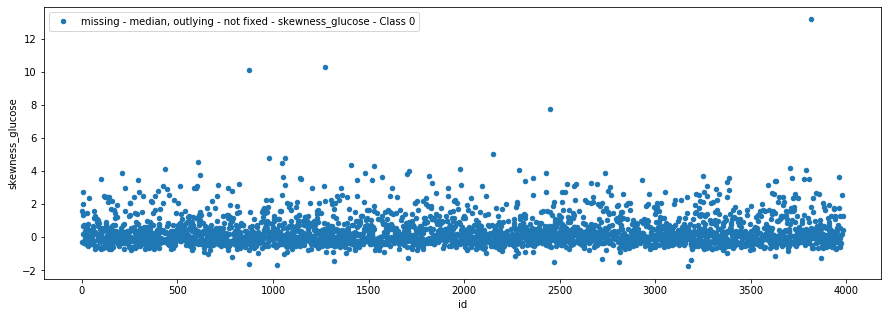

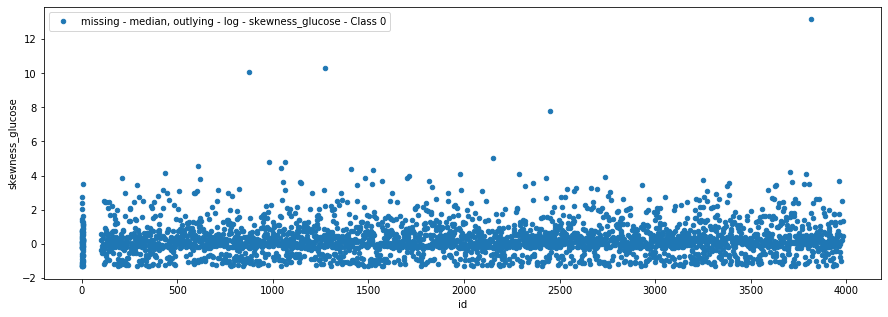

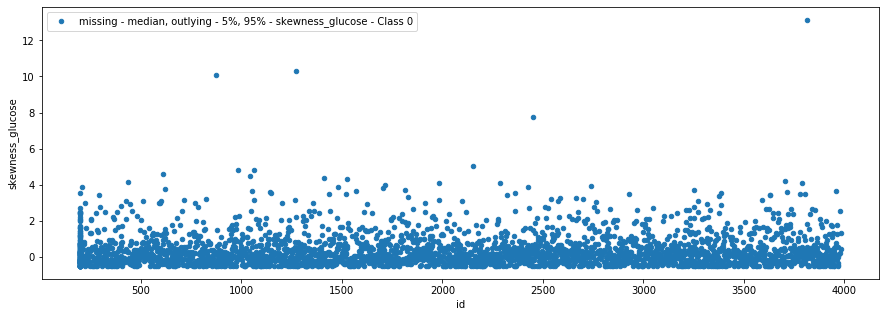

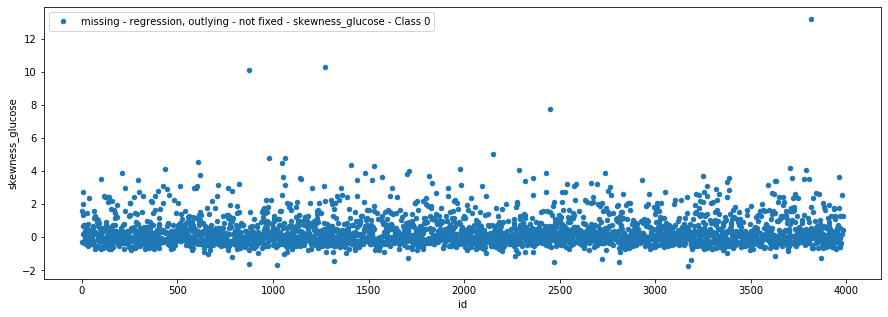

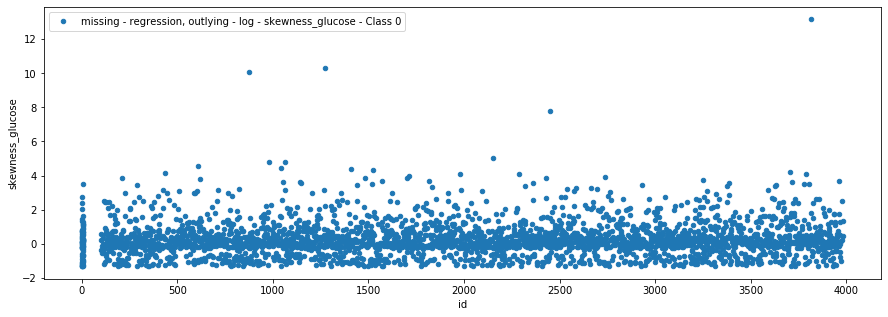

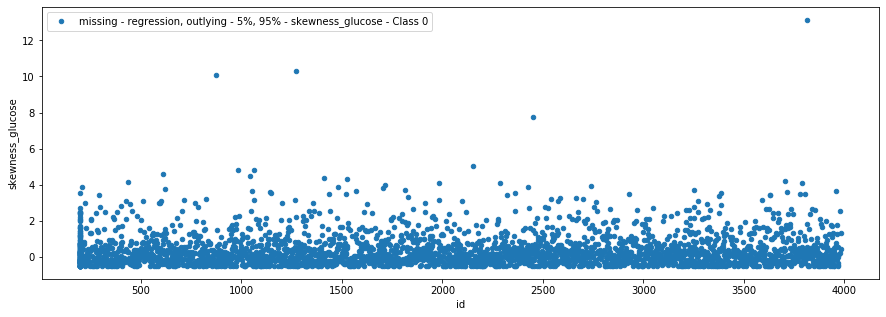

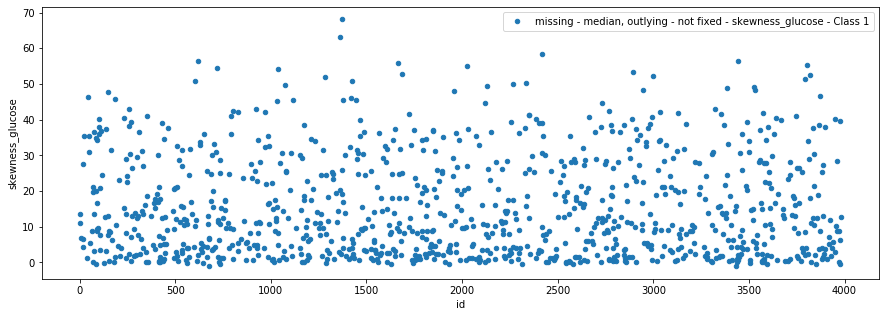

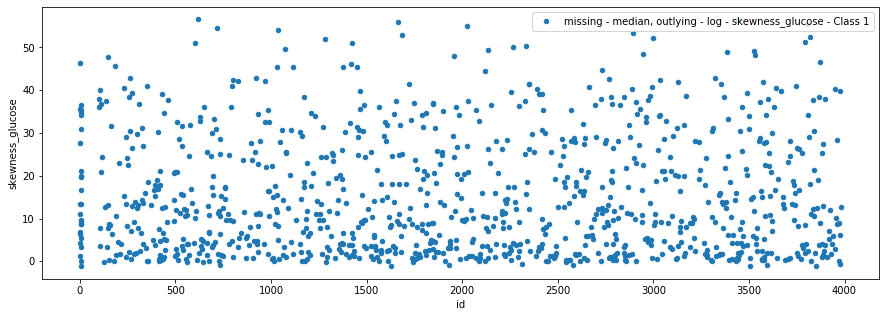

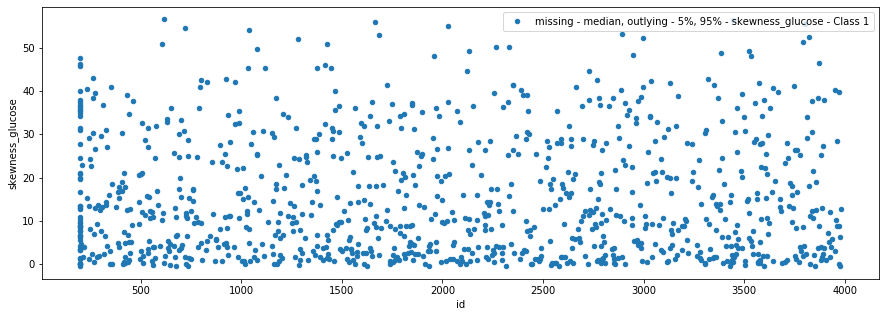

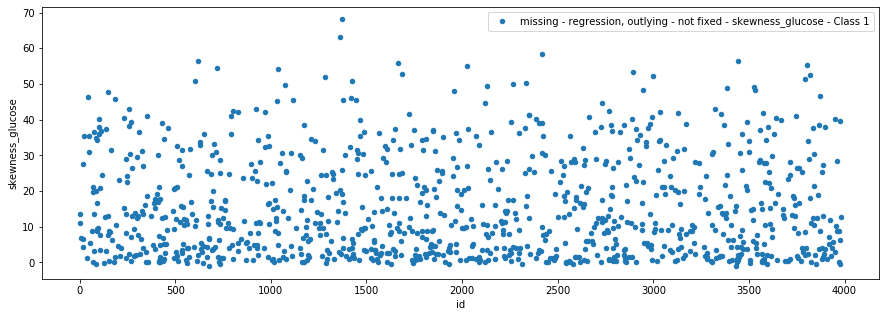

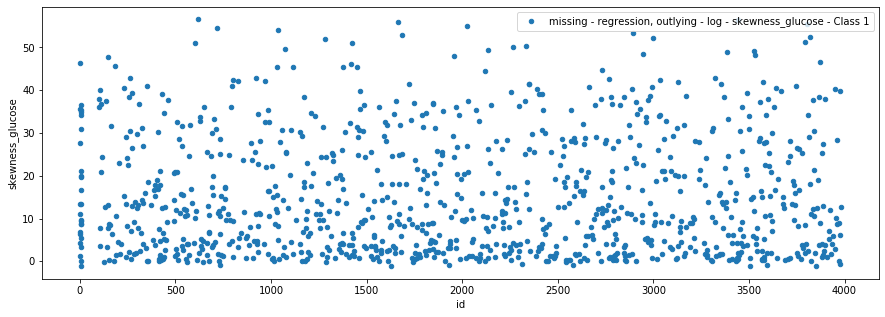

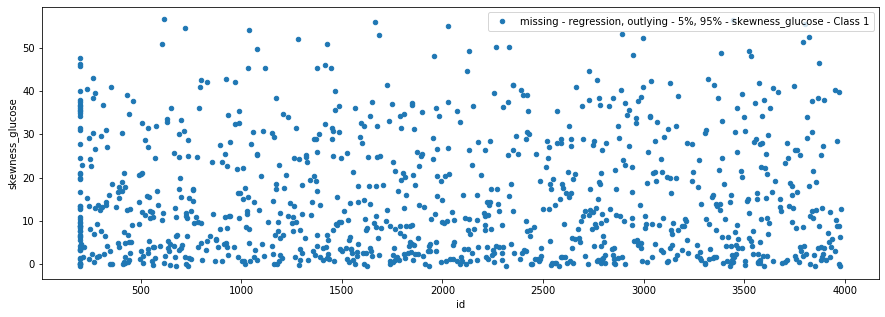

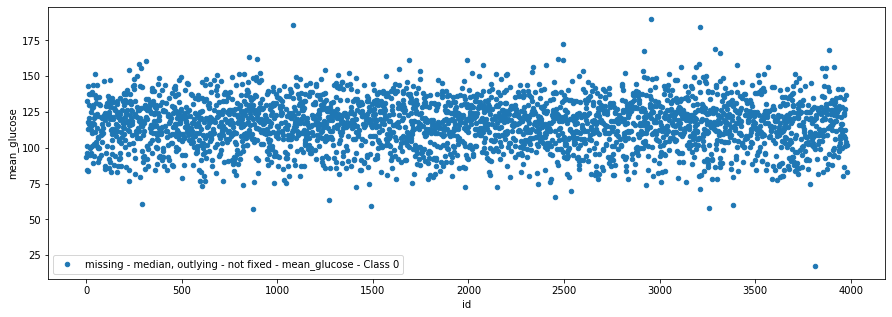

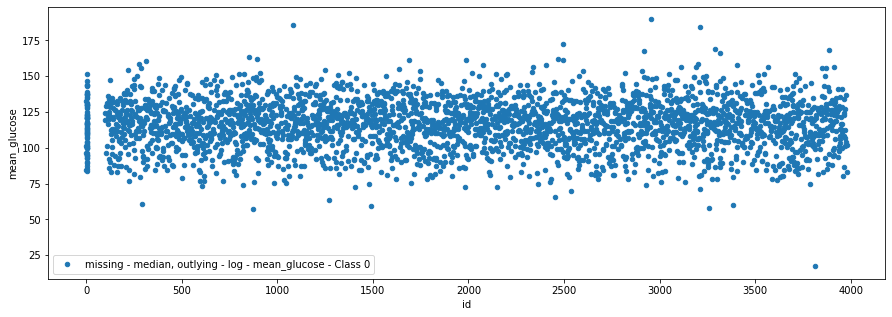

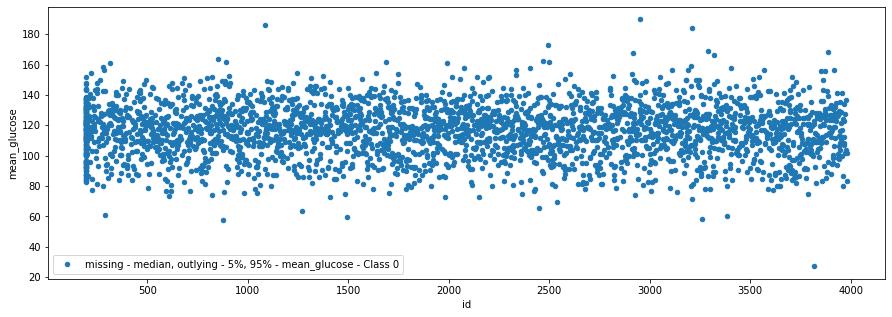

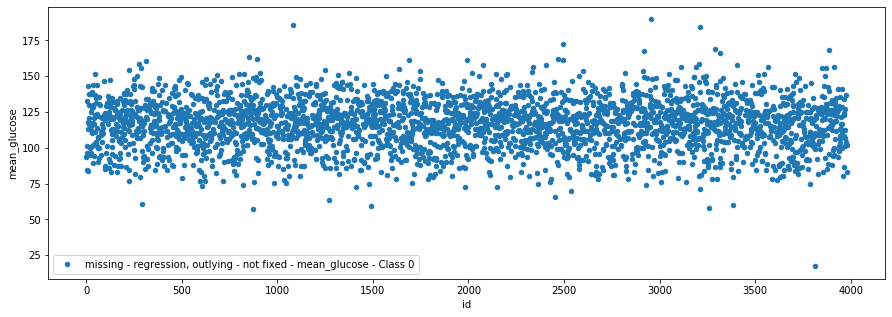

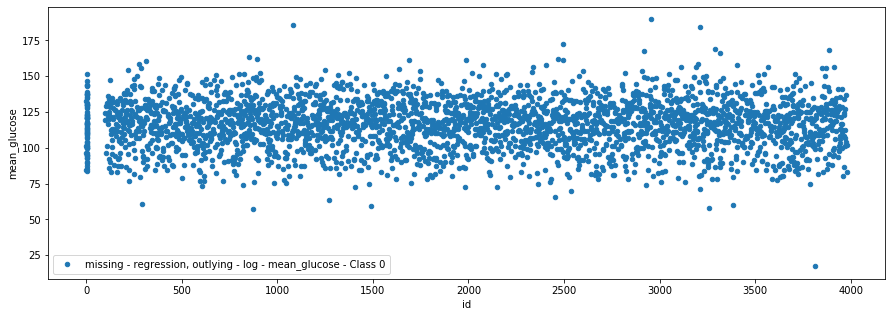

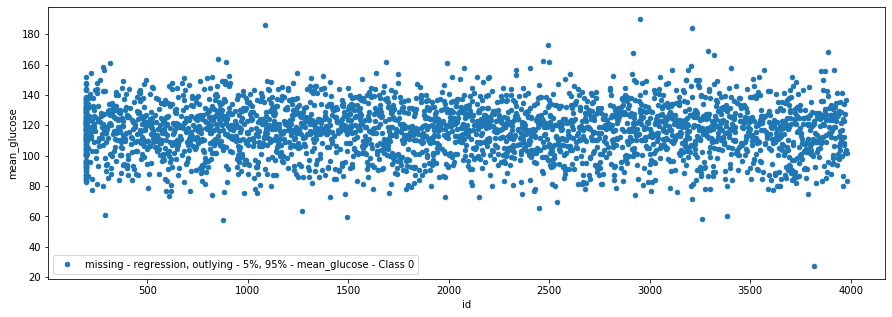

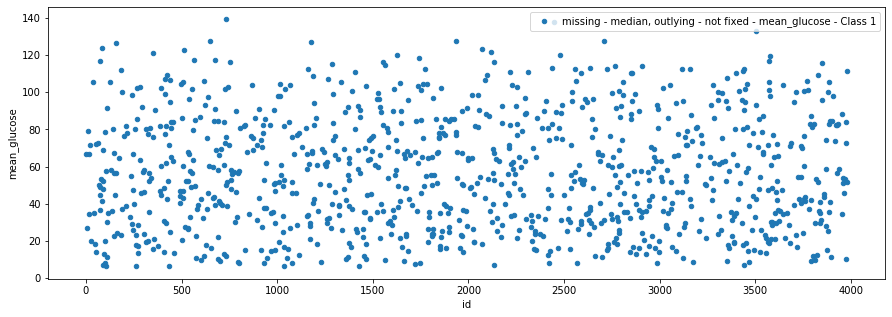

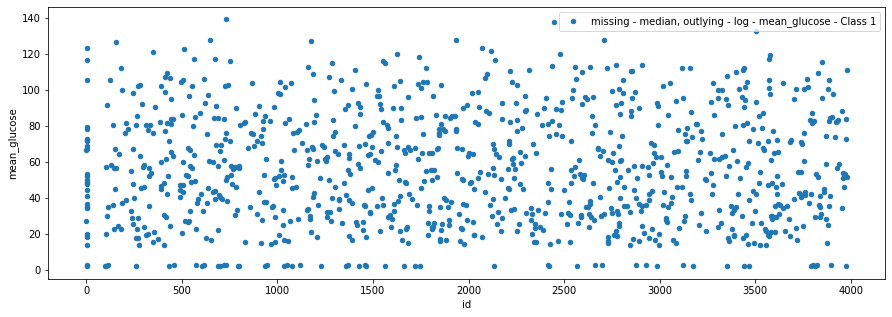

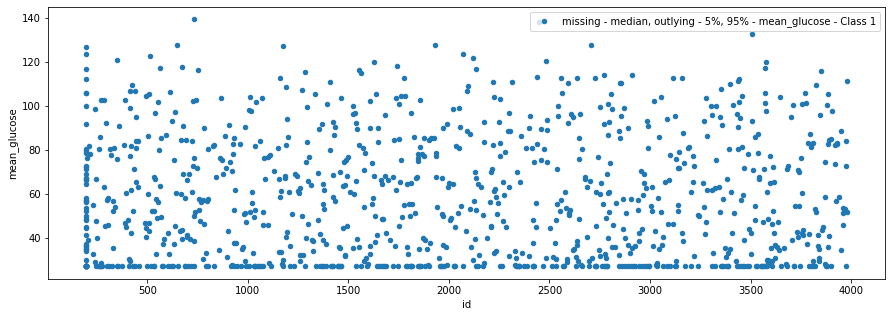

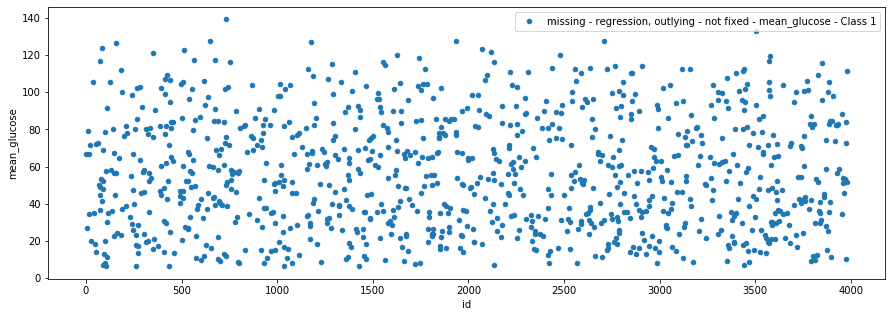

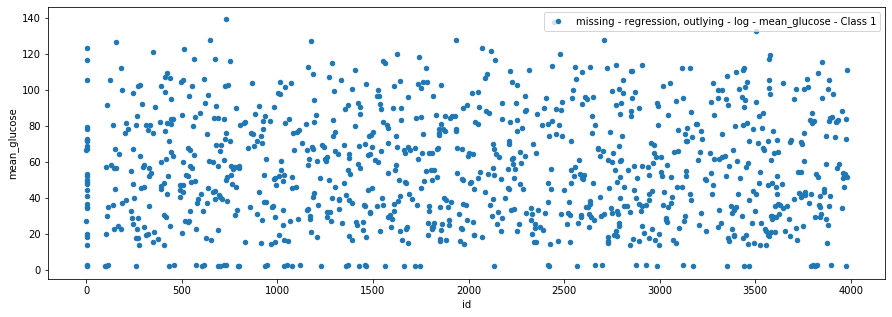

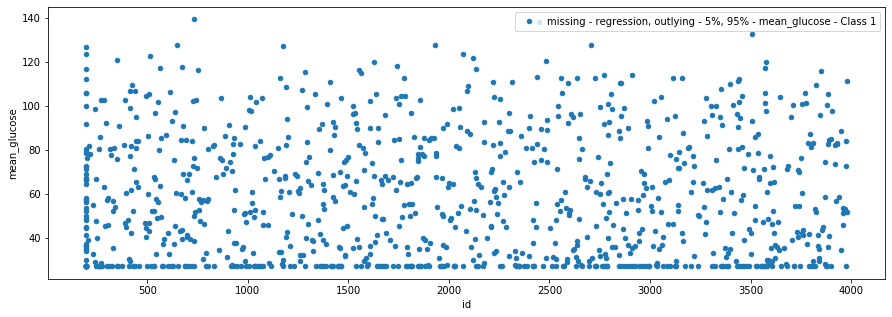

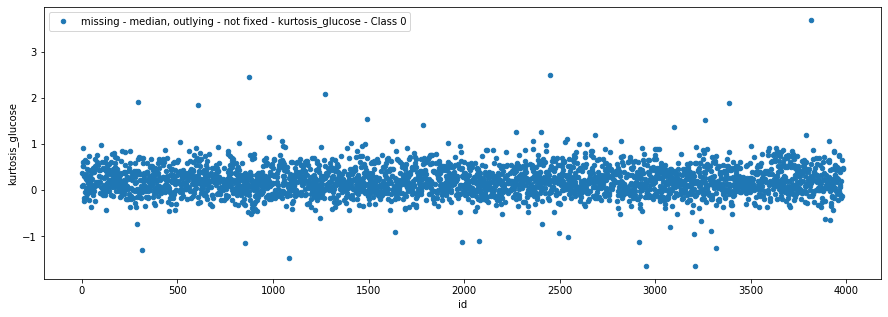

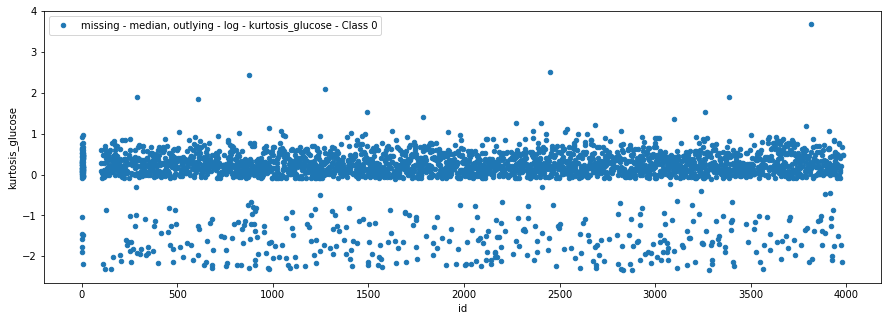

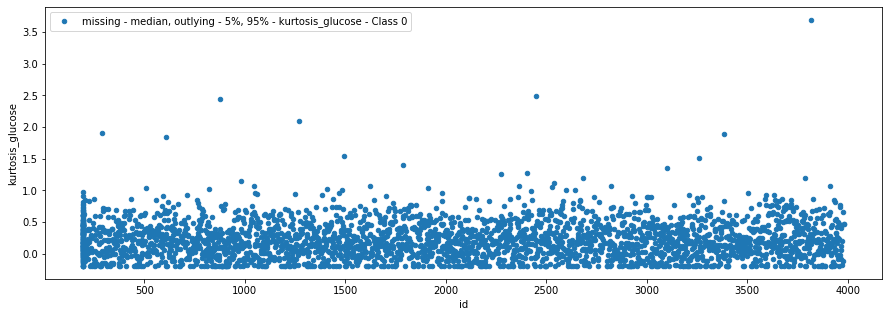

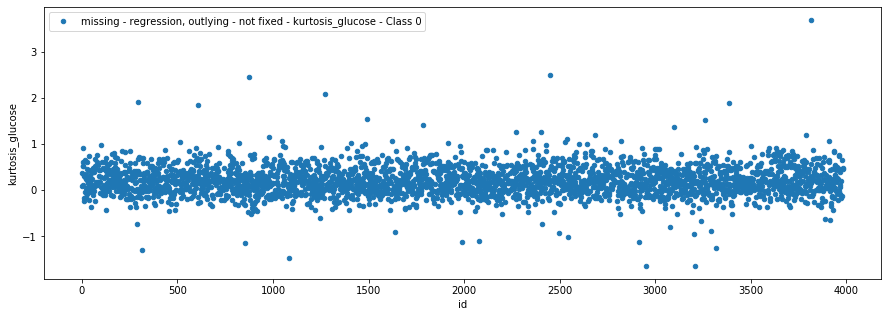

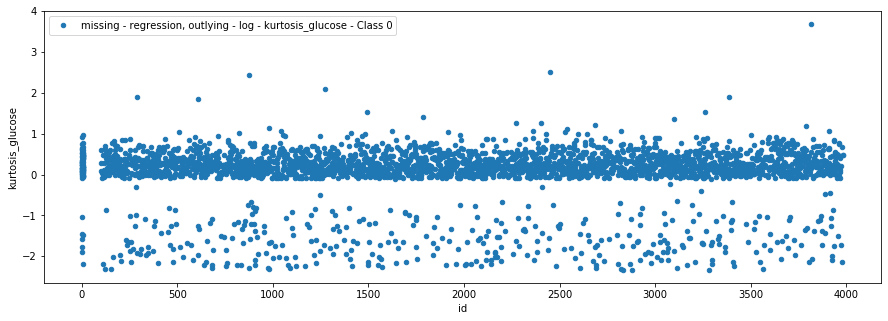

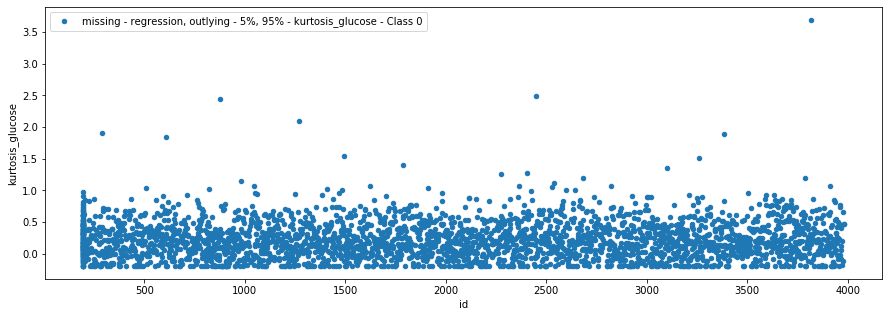

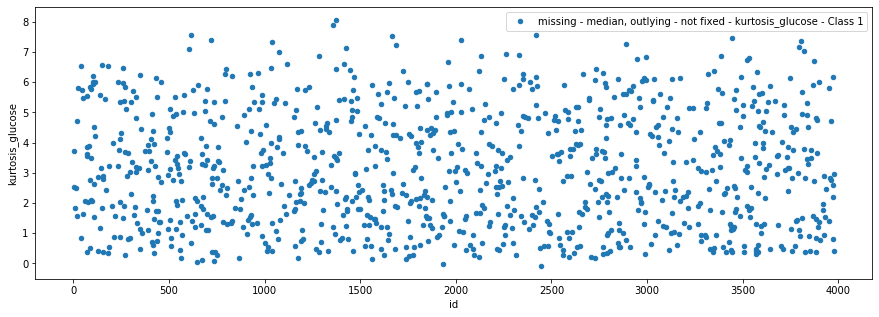

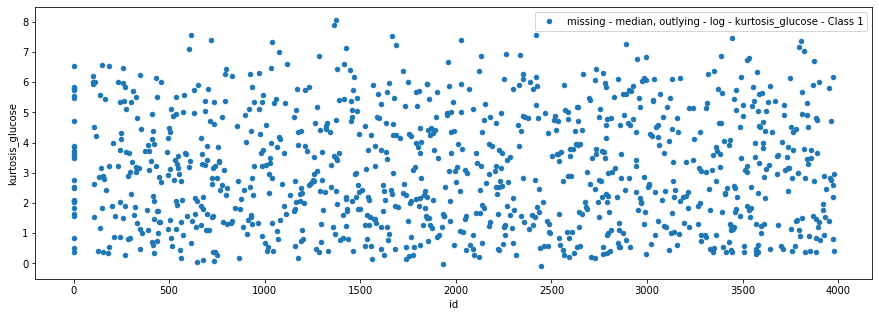

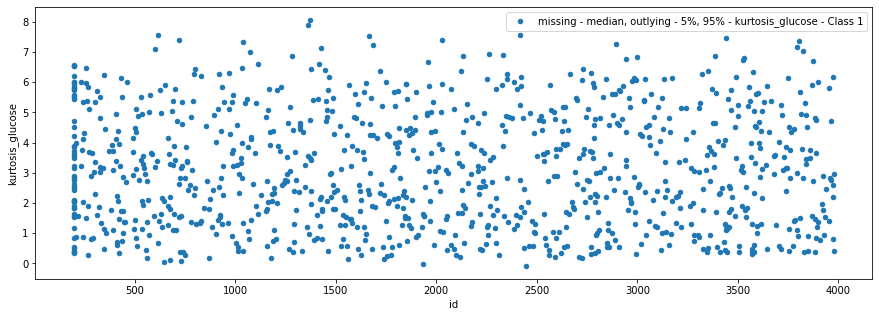

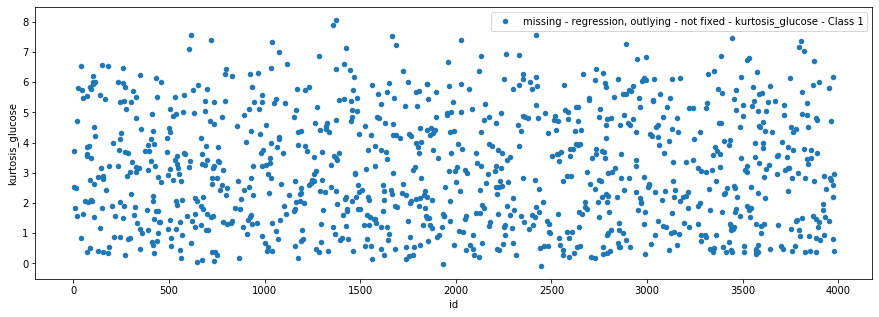

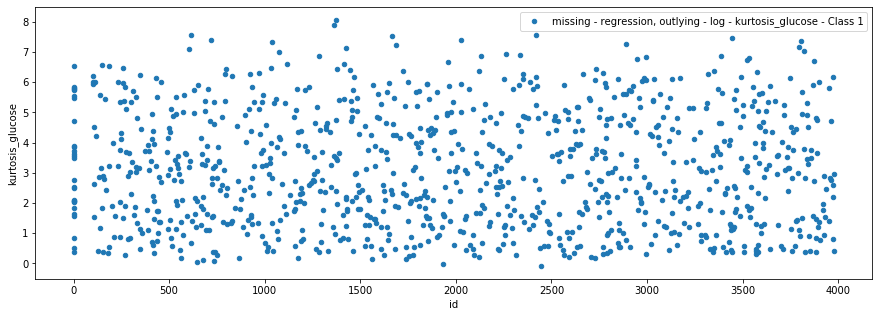

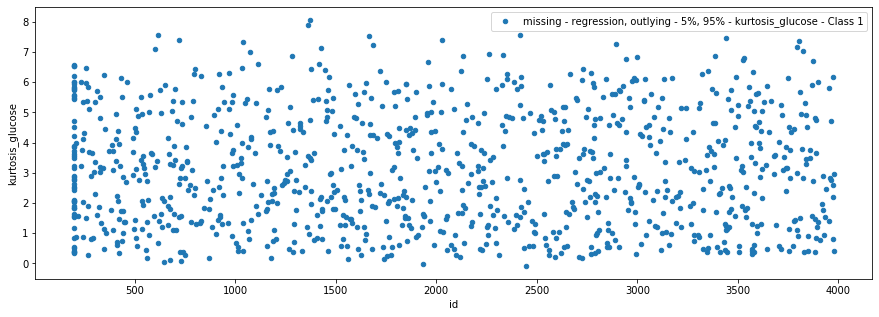

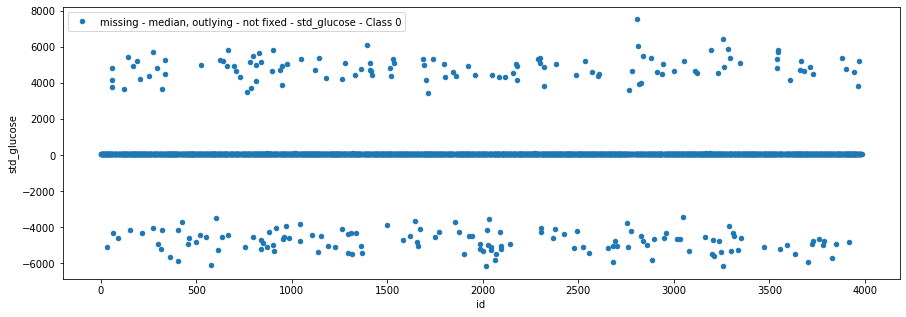

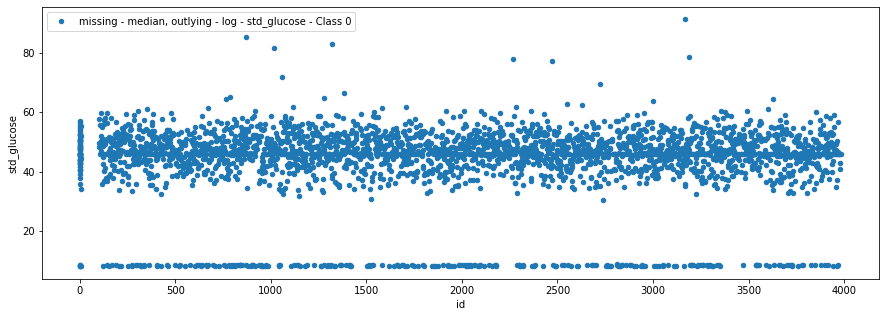

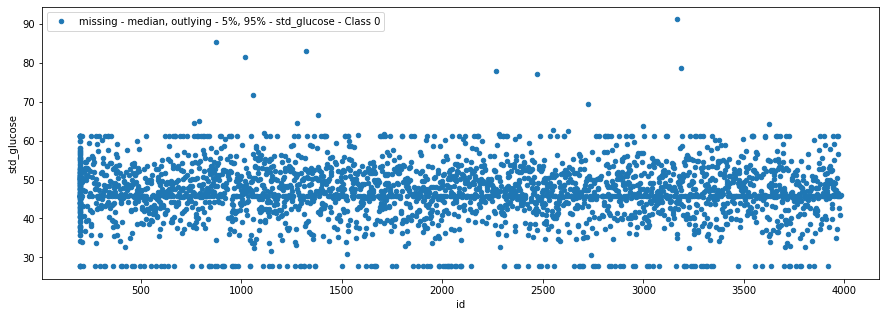

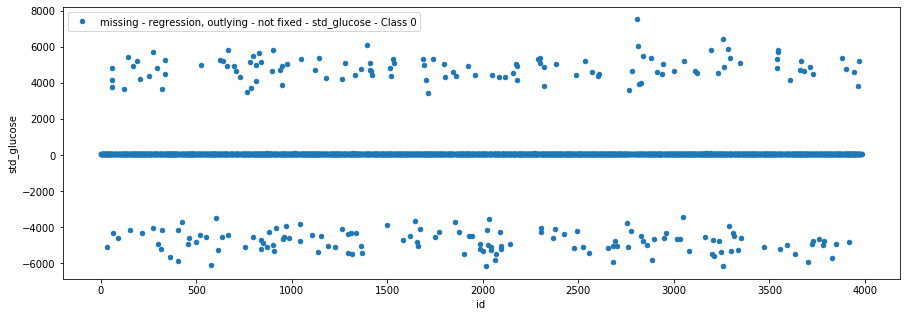

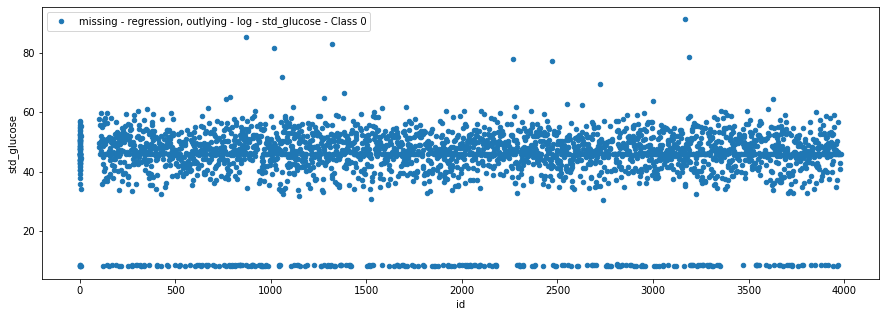

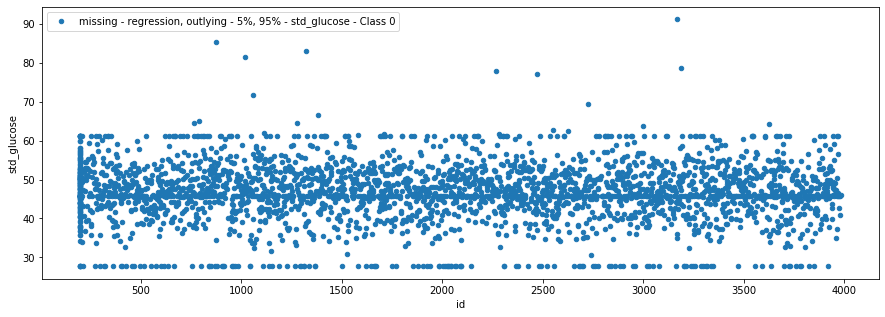

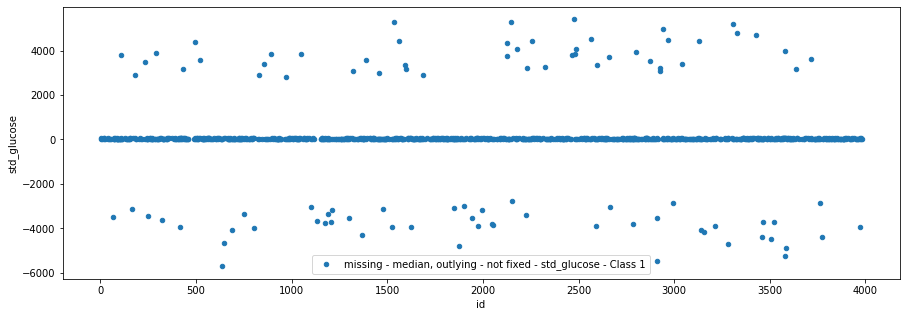

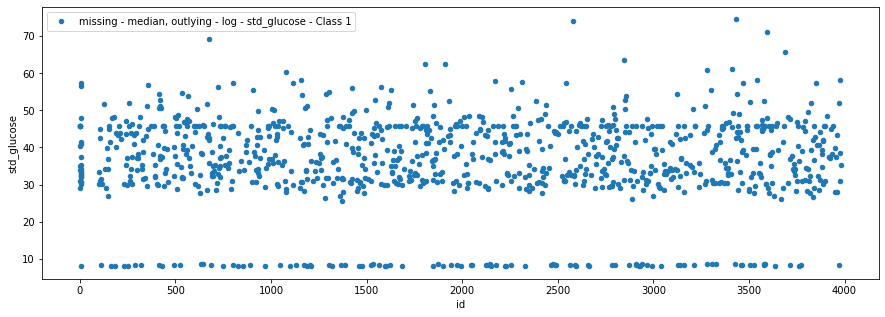

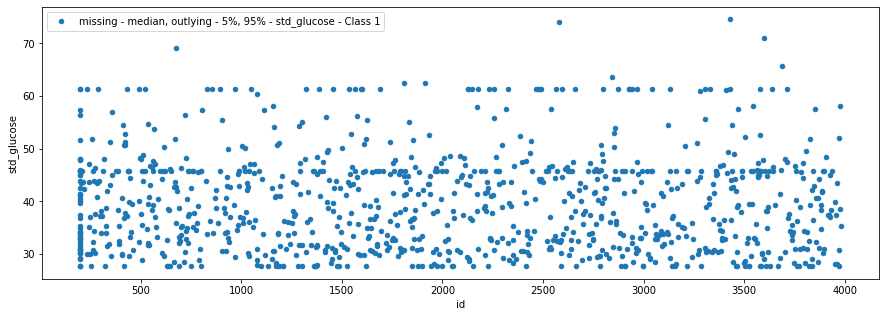

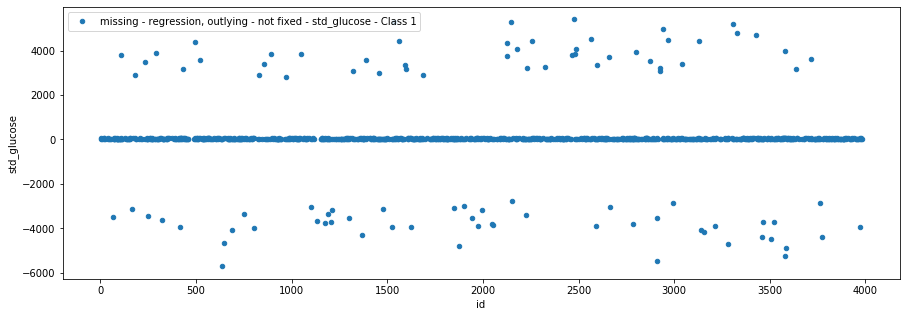

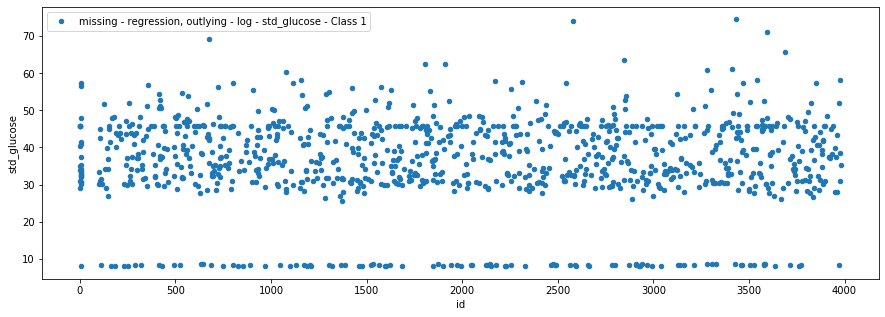

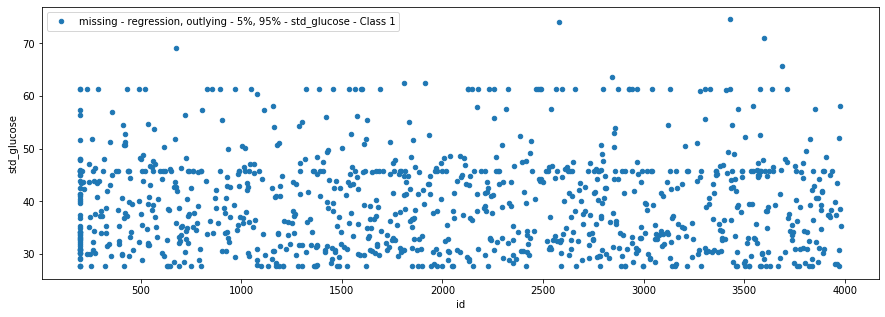

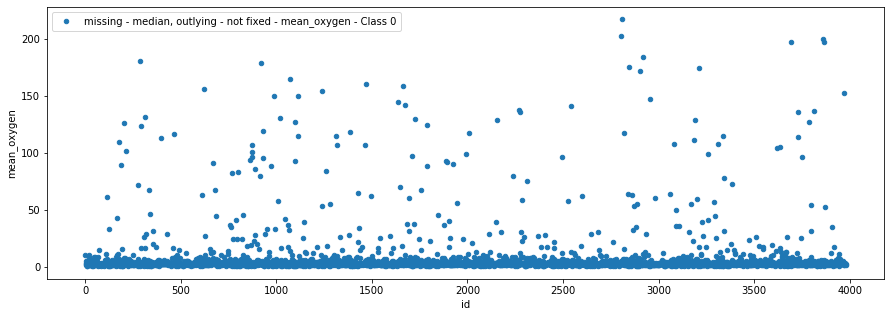

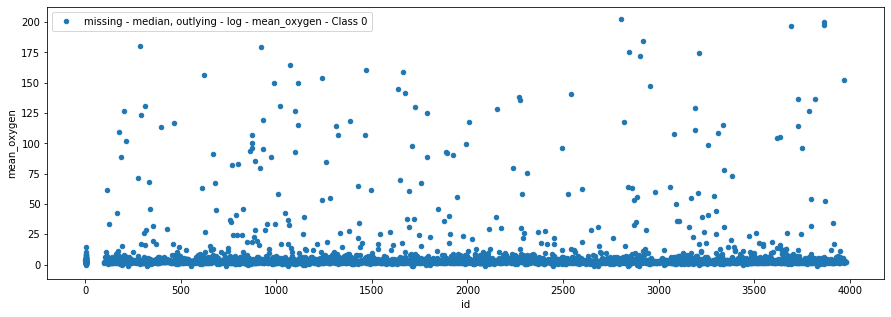

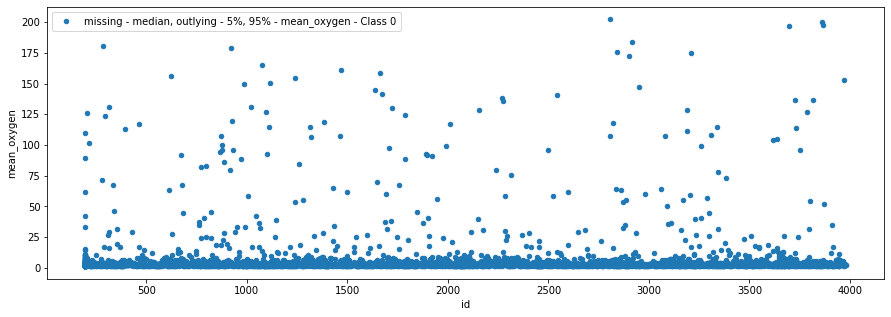

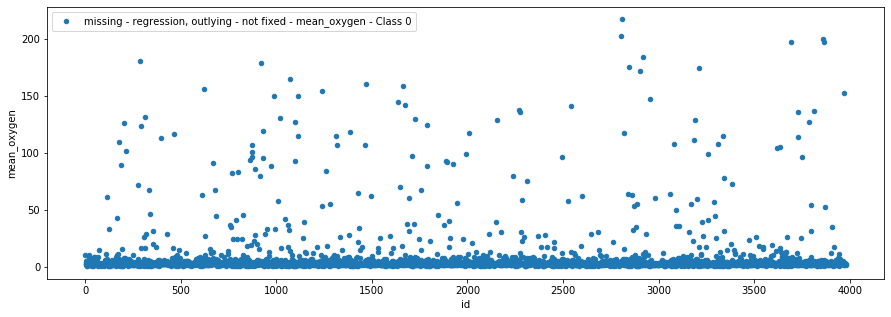

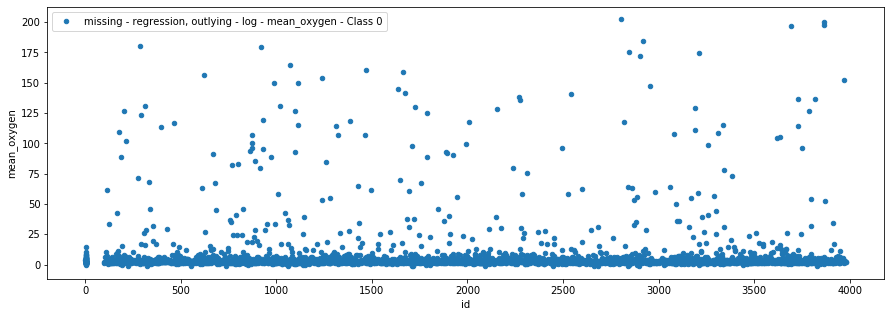

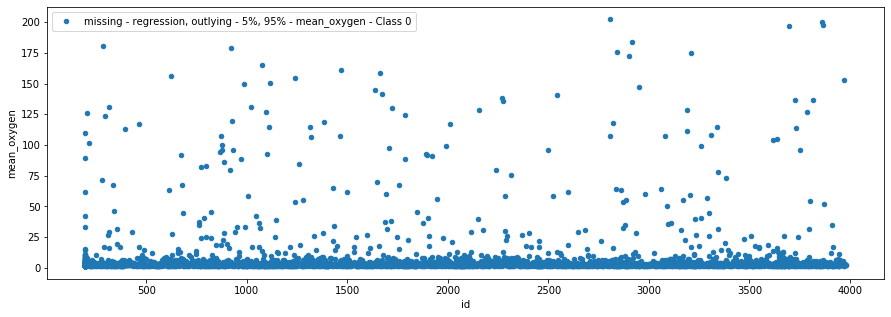

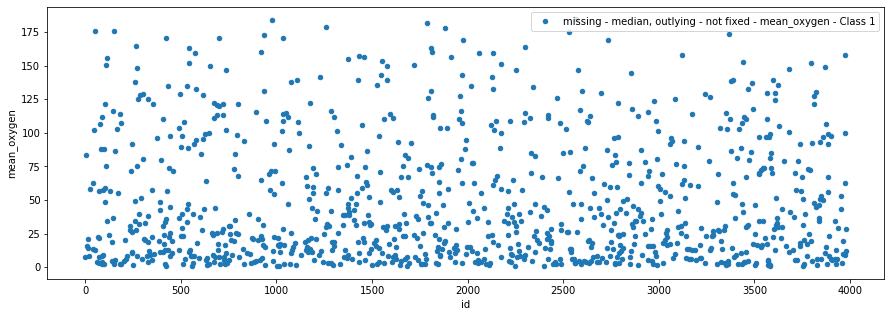

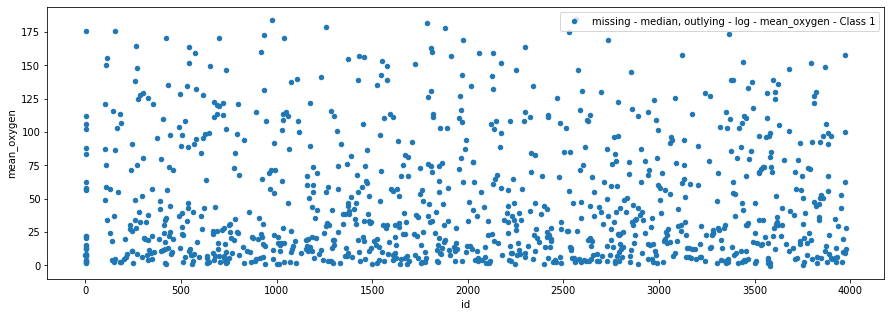

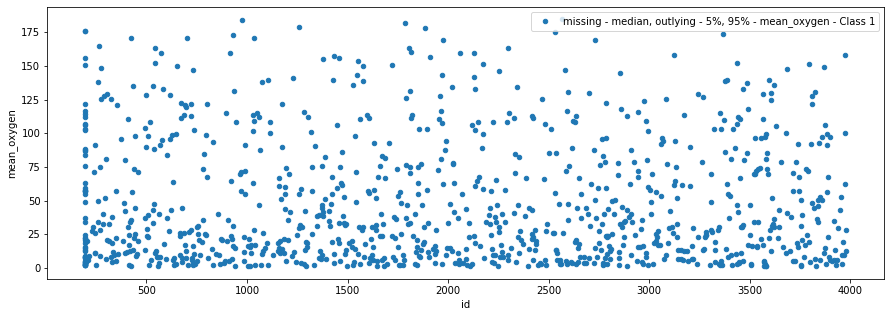

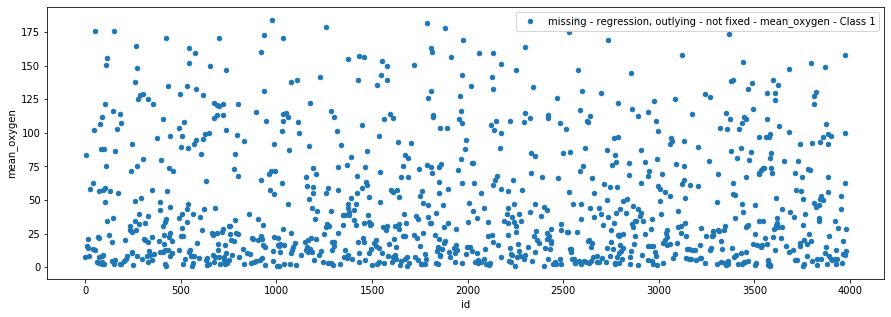

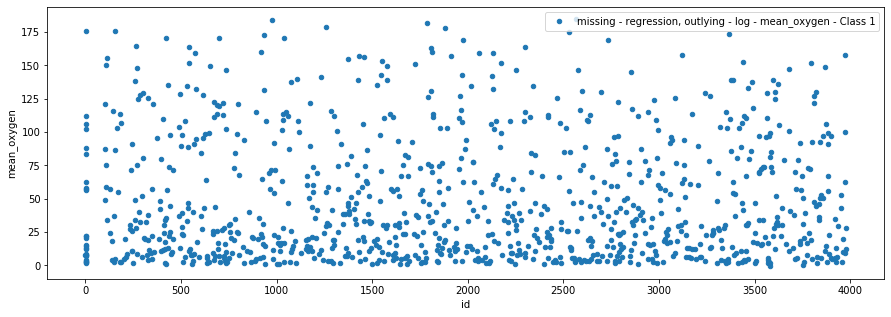

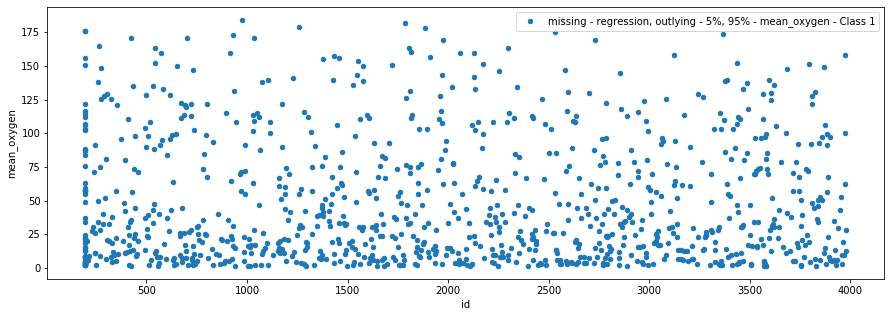

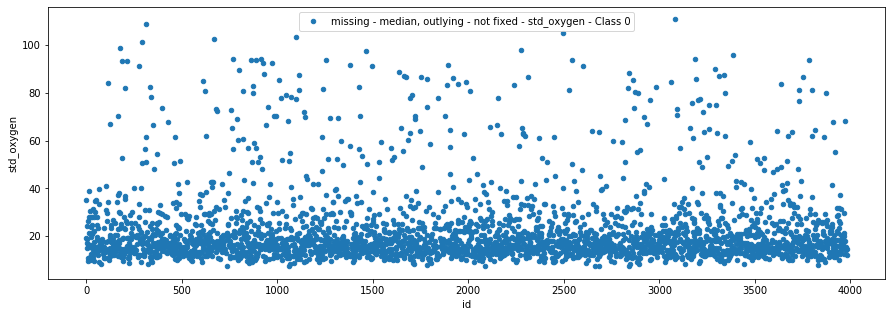

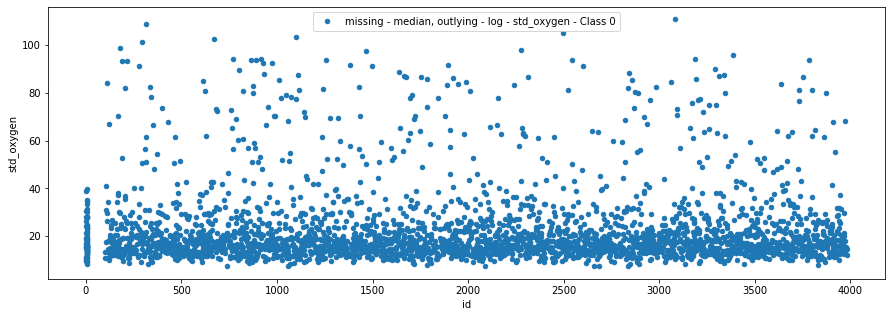

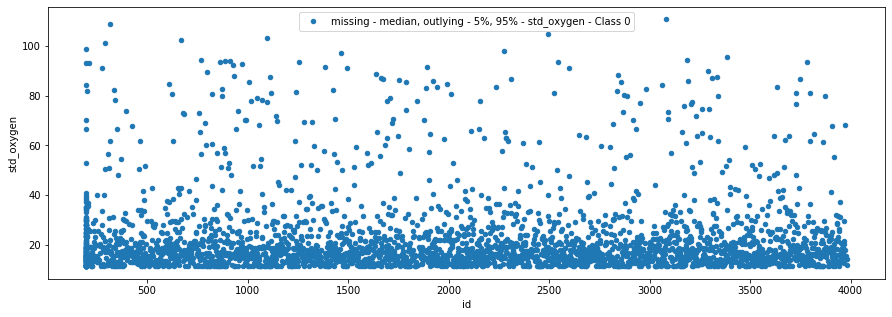

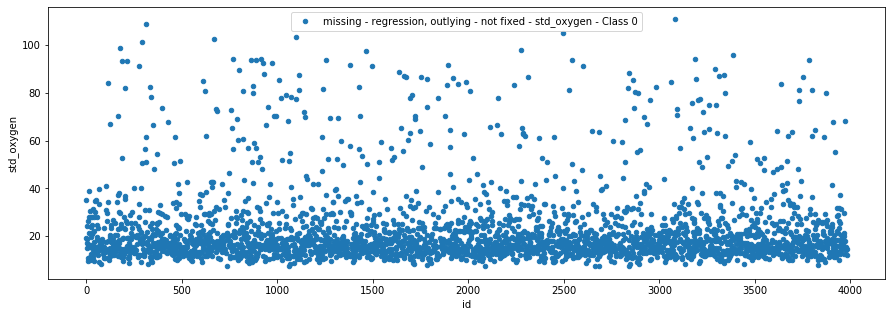

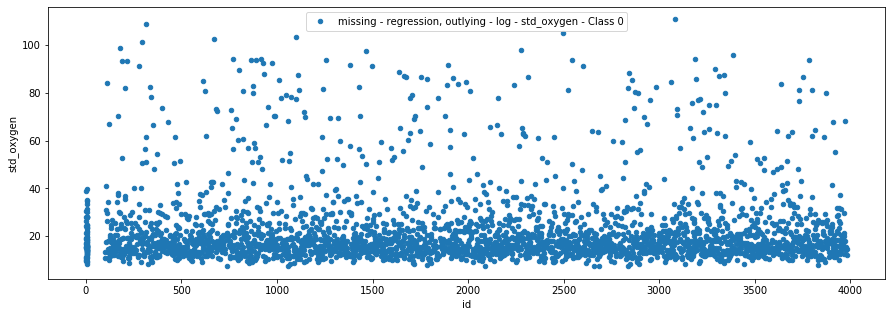

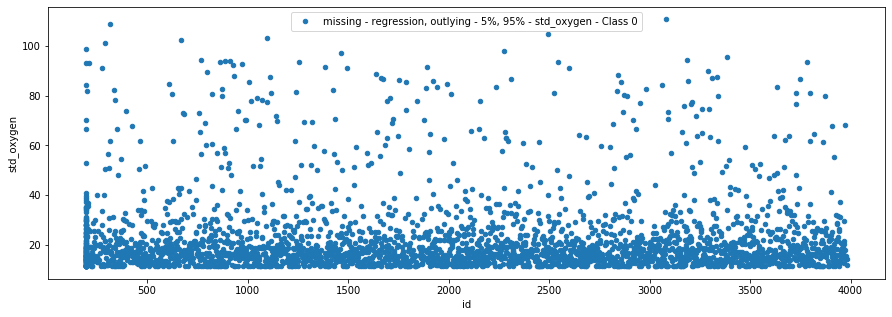

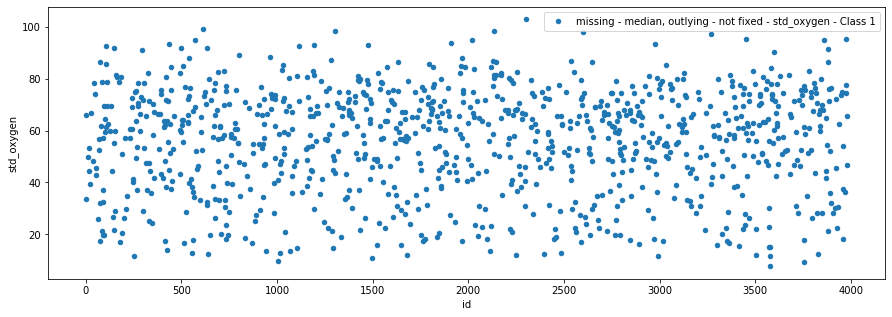

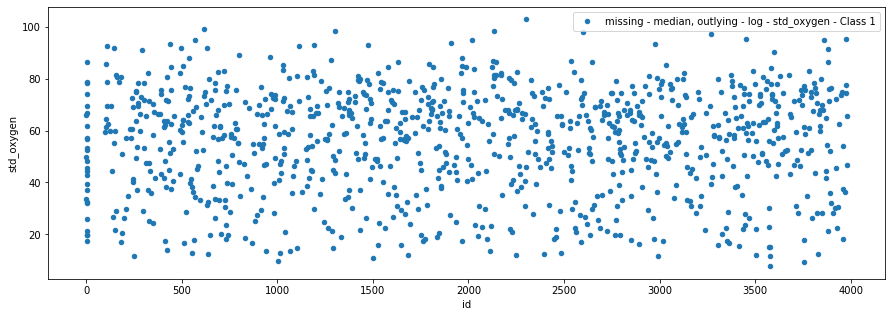

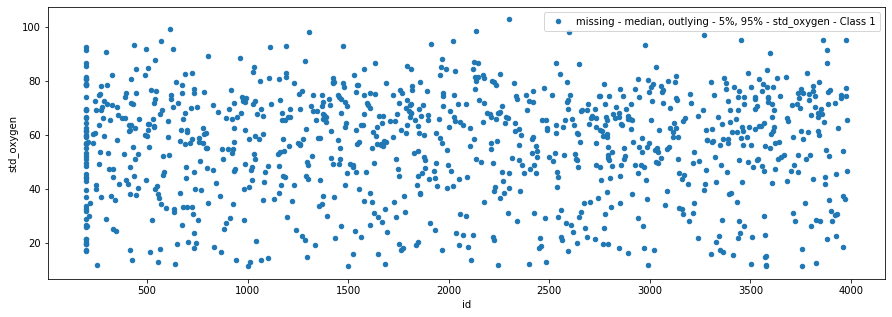

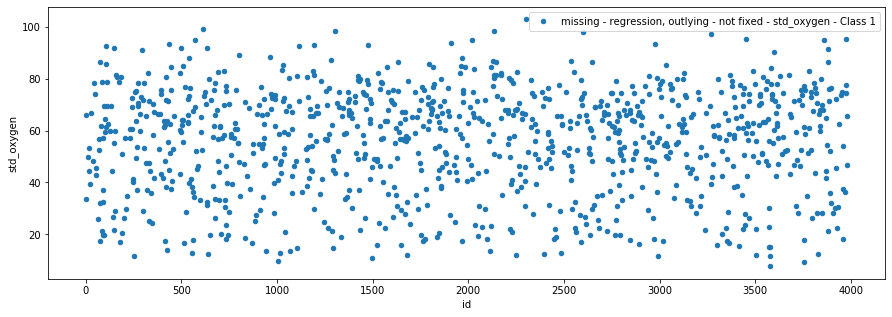

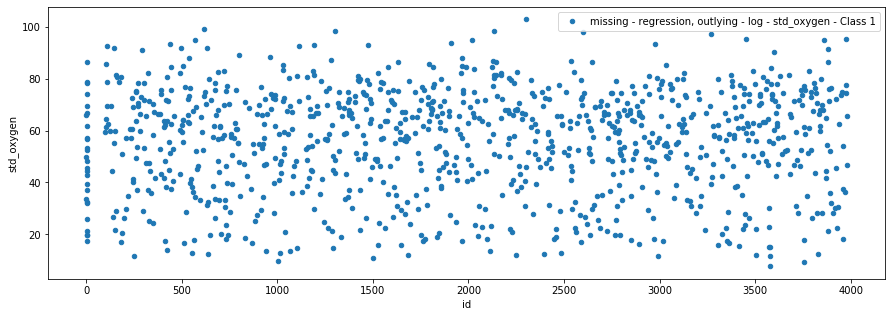

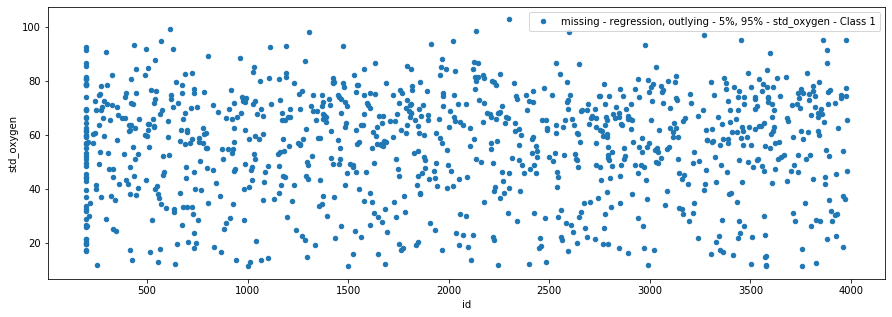

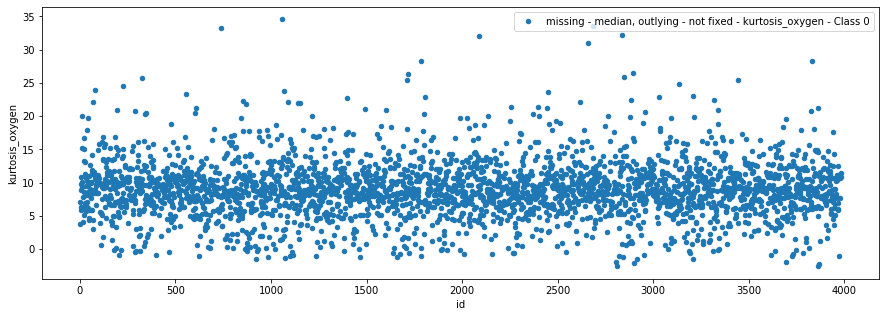

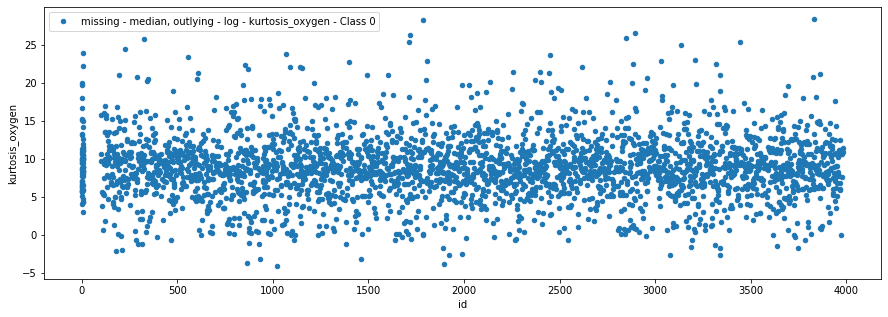

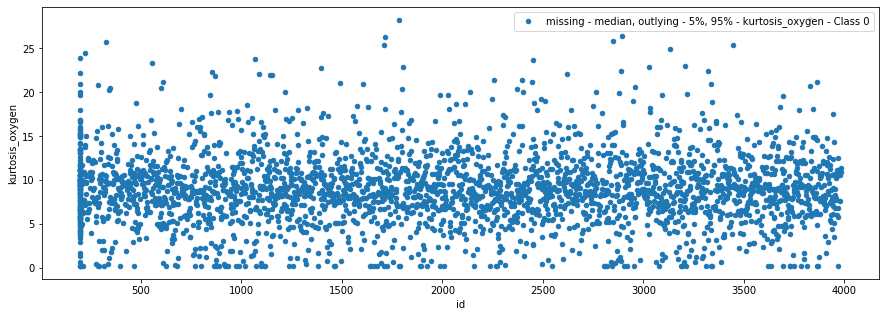

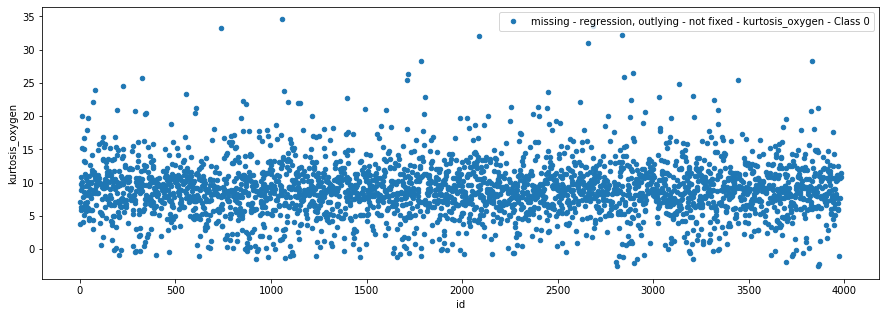

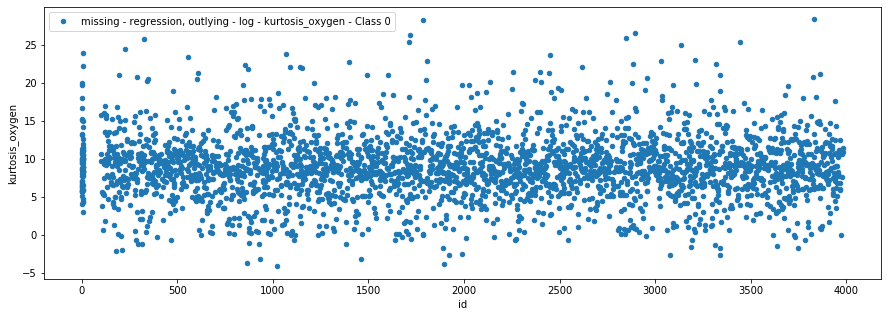

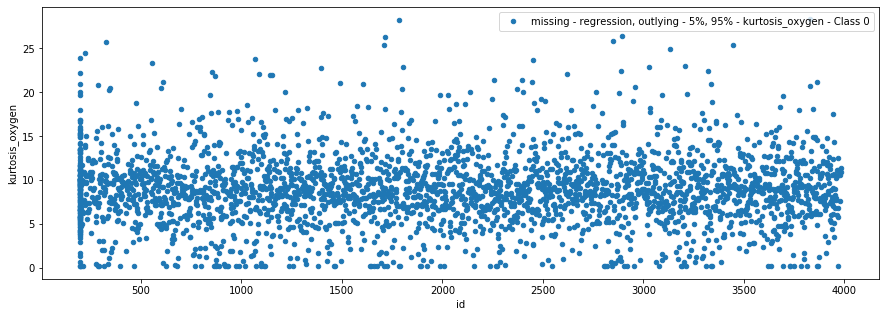

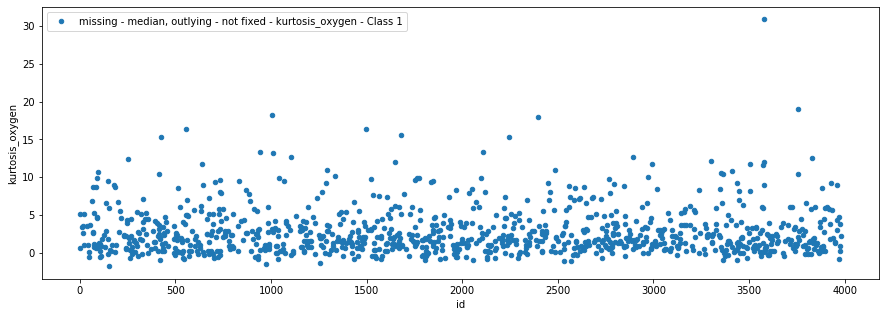

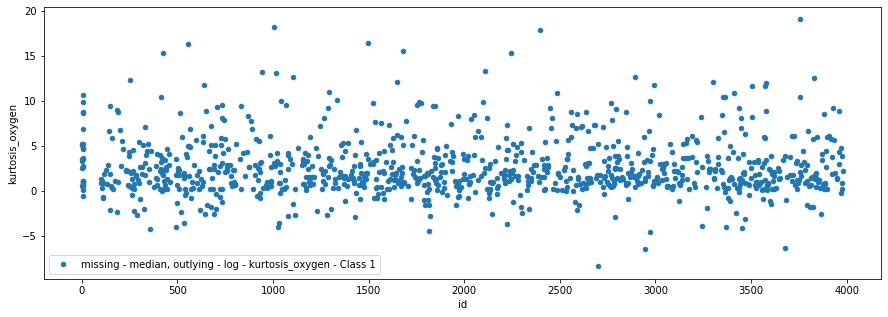

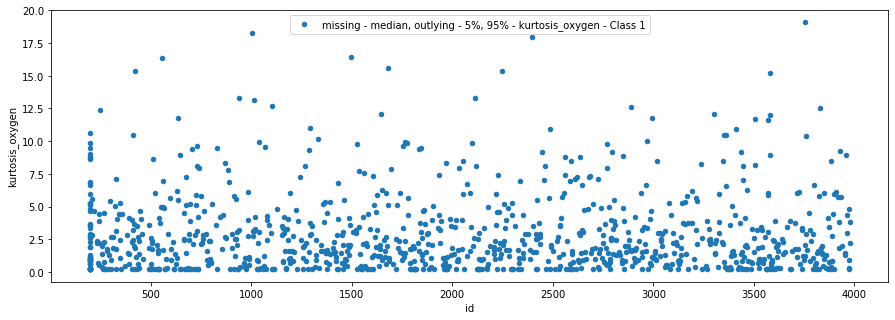

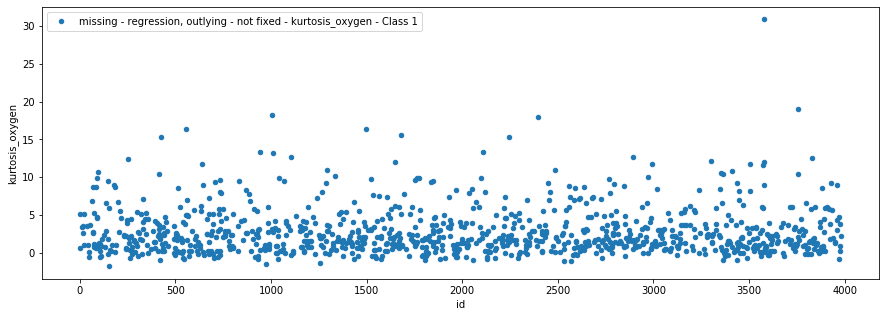

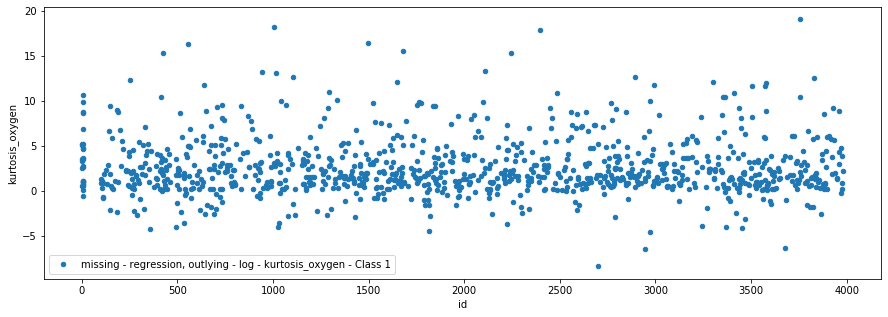

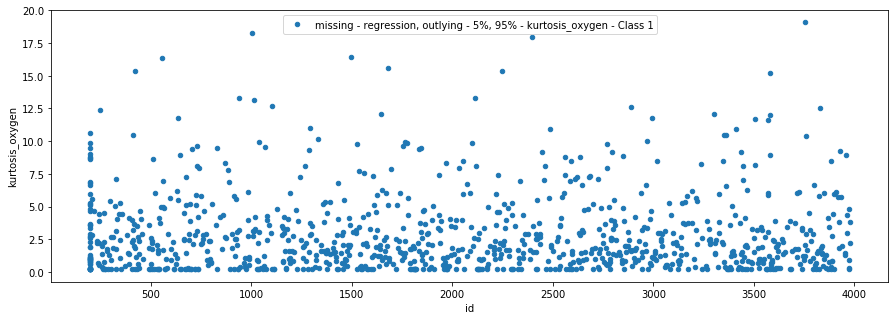

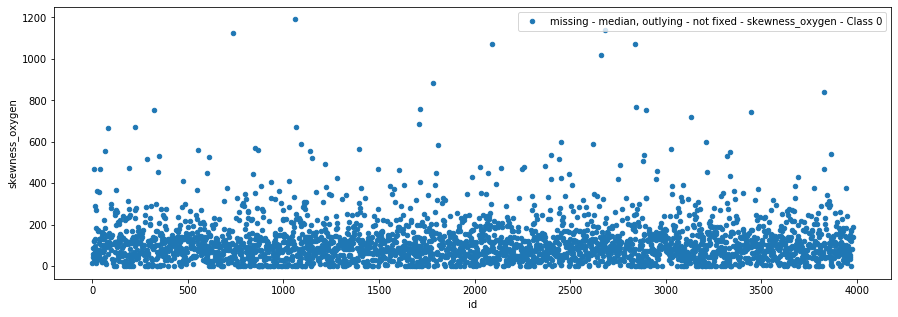

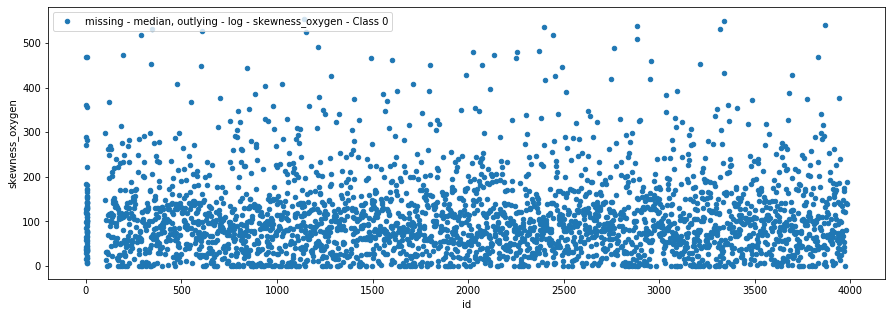

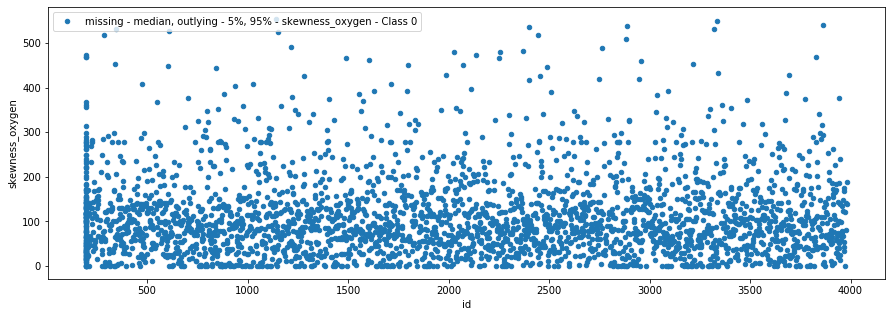

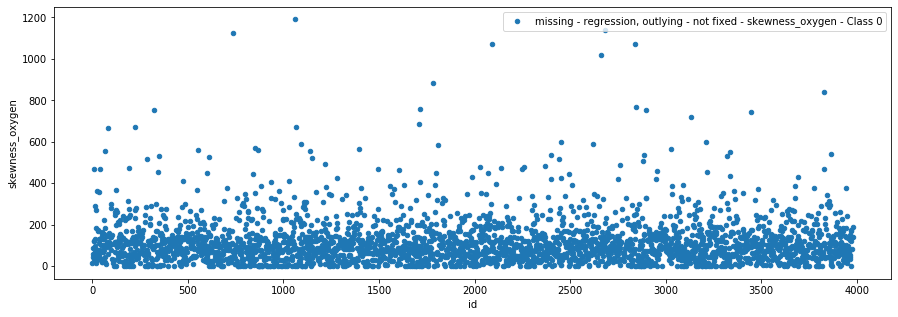

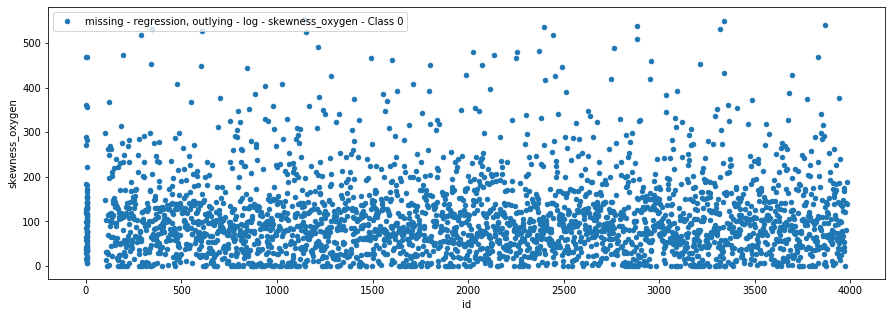

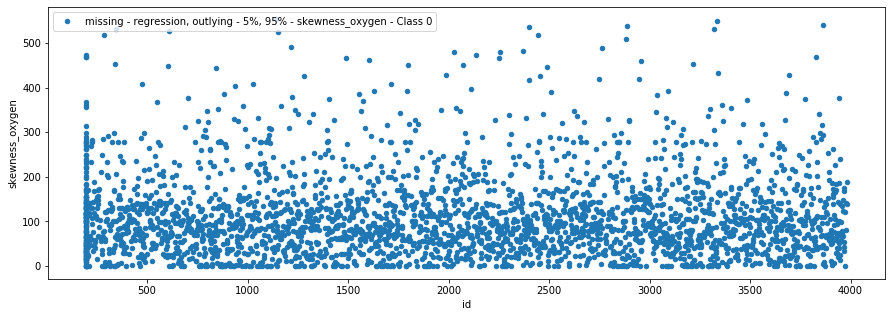

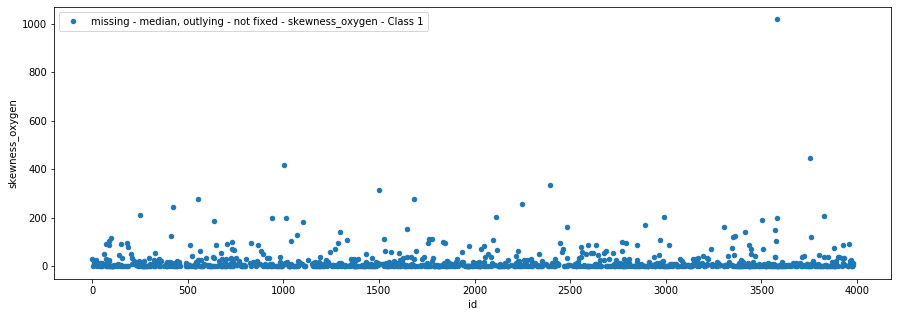

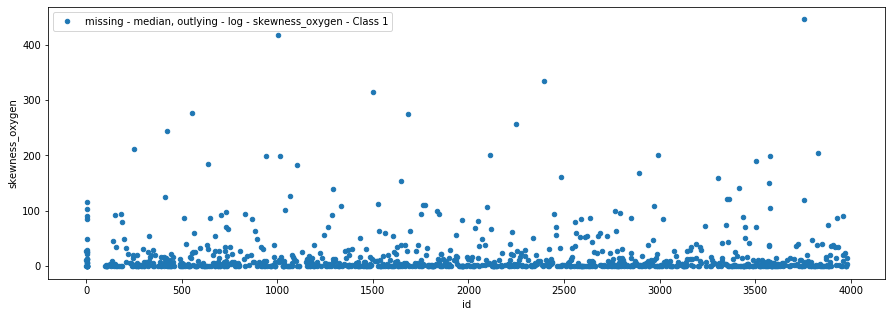

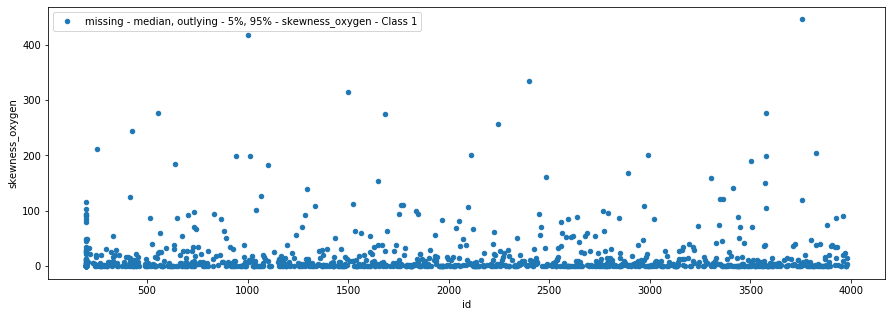

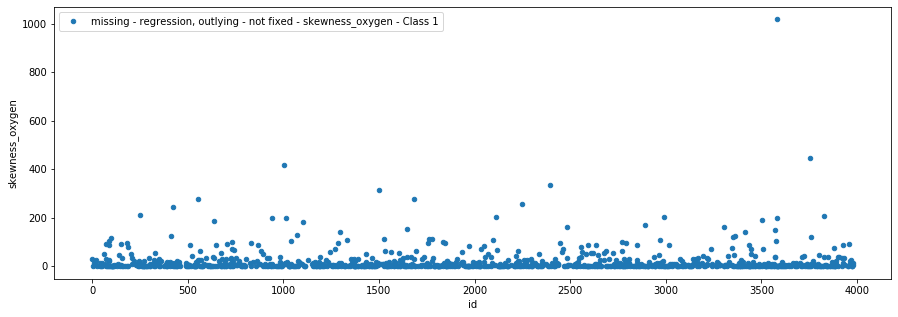

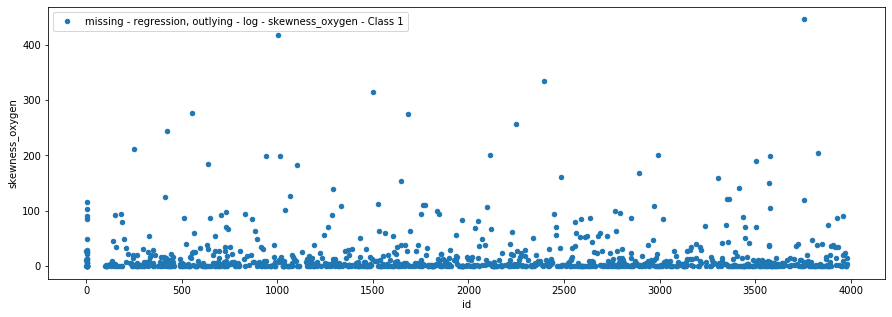

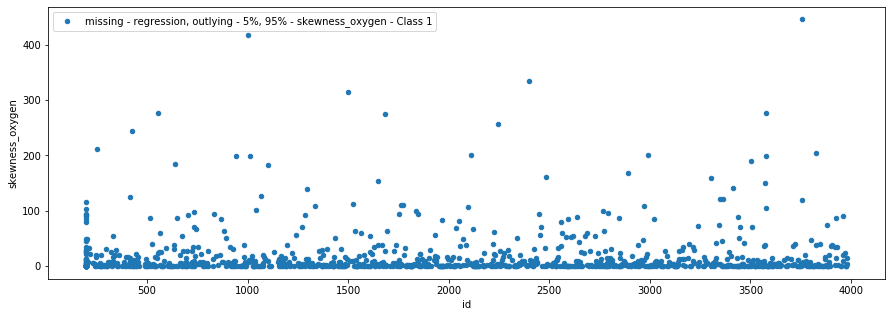

In [23]:
# Fix train data
print_data_stats('BEFORE FIX', data, data2)
data, data2 = fix_train_data(data, data2, True)
print_data_stats('AFTER FIX', data, data2)

# Testing space

In [24]:
std_g_pp = np.percentile(data2["std_glucose"], 95)
std_g_pp

61.24722886999997

In [25]:
std_g_pm = np.percentile(data2["std_glucose"], 5)
std_g_pm

27.675204036800004

In [26]:
def fix_std_g(x):
    if x > 200:
        x = std_g_pp
    if x < -200:
        x = std_g_pm
    return x

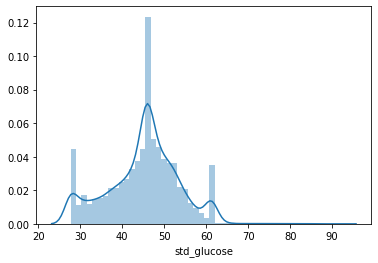

In [27]:
sea.distplot(data2["std_glucose"])

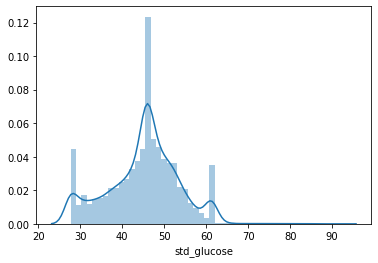

In [28]:
sea.distplot(data2["std_glucose"].apply(fix_std_g))

In [29]:
data2["std_glucose"] = data2["std_glucose"].apply(fix_std_g)

In [30]:
s_o_pp = np.percentile(data2["skewness_oxygen"], 95)
s_o_pp

277.132996716

In [31]:
def fix_s_o(x):
    if x > 300:
        x = s_o_pp
    return x

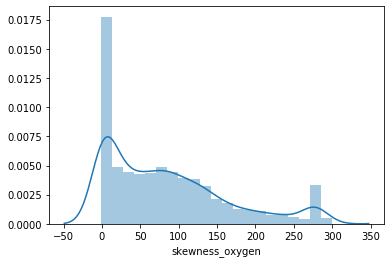

In [32]:
sea.distplot(data2["skewness_oxygen"].apply(fix_s_o))

In [33]:
data2["skewness_oxygen"] = data2["skewness_oxygen"].apply(fix_s_o)

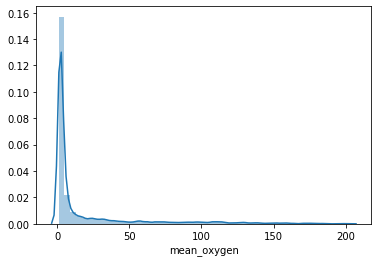

In [34]:
sea.distplot(data2["mean_oxygen"])

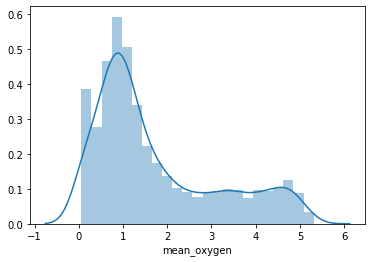

In [35]:
sea.distplot(np.log(data2["mean_oxygen"]))

In [36]:
data2['mean_oxygen'] = np.log(data2['mean_oxygen'])

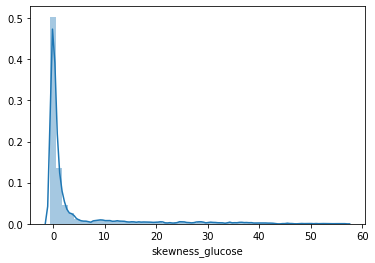

In [37]:
sea.distplot(data2['skewness_glucose'])

In [38]:
s_g_pp = np.percentile(data2['skewness_glucose'], 95)
s_g_pp

28.8129993756

In [39]:
def fix_s_g(x):
    if x > 45:
        x = s_g_pp
    return x

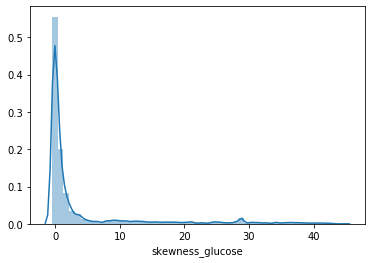

In [40]:
sea.distplot(data2['skewness_glucose'].apply(fix_s_g))

# Documentation

## Opätovná realizácia podstatných častí prieskumnej analýzy

**Všeobecné**
- Niektoré stĺpce obsahovali medzeru pred hodnotou. Tieto medzeri sme odstránili

- Spájanie riadkov v prípade duplicitných záznamov: pokiaľ záznam obsahuje “nan” alebo “?”, doplní sa z iného záznamu. Pokiaľ oba záznamy obsahujú hodnotu v stĺpci, numerické hodnoty zapíšu priemer hodnôt a nenumerické hodnoty vyberú prvú z možností 

**Date_of_birth**
- Dátum je spracovaný do formátu yyyy-mm-dd. Boli z neho odstránené časy narodenia. „/“ bola nahradená „-“. Rok narodenia zapísaný v tvare napr. 68 (1968) bol podľa veku upravený na požadovaný formát.

**Age**
- Z upravených dátumov narodenia sa dopočítal chýbajúci vek

**Sex**
- Zjednotené na "Male" "Female" 

**Pregnant**
- Hodnoty boli zjednotené na „True“ a „False“

**Education_num**
- „nan“ hodnoty boli nahradené mediánom

**Income**
- Zjednotené na 2 hodnoty “>50K“ a „<=50K” pomocou mediánu

**Class**
- Hodnoty sme zmenili na integer a obsahujú len hodnoty “1” a “0”

**Std_glucose**
- Chýbajúce hodnoty boli dopočítané priemerom. Odľahlé hodnoty sme nahradili hraničnou hodnotou rozdelenia  - 95 percentilom a 5 percentilom

**Skewness_oxygen**
- Chýbajúce hodnoty boli dopočítané priemerom. Odľahlé hodnoty sme nahradili hraničnou hodnotou rozdelenia  - 95 percentilom

**mean_oxygen**
- Chýbajúce hodnoty boli dopočítané priemerom. Odľahlé hodnoty sme nahradili logaritmom hodnôt.

**Skewness_glucose**
- Chýbajúce hodnoty boli dopočítané priemerom. Odľahlé hodnoty sme nahradili hraničnou hodnotou rozdelenia  - 95 percentilom

**Std_oxygen, mean_glucose, kurtosis_glucose, kurtosis_oxygen**
- Chýbajúce hodnoty boli nahradené priemerom

**Capital_loss, capital_gain, fnlwgt, hour-per-week**
- Chýbajúce hodnoty boli nahradené mediánom

**Education, marital_status, native-country, occupation, race, relationship, workclass**
- Chýbajúce hodnoty boli doplnené najčastejšie sa vyskytujúcim prvkom



## Znovupoužiteľnosť predspracovania

Keďže je naša oprava dát písaná vo funkciach je dobre použiteľná aj na ďalšie datasety. Funkcia fix_date_format opraví akýkoľbvek formát dátumu do nášho požadovaného formátu. Funkcia calc_missing_ages_from_date_of_birth dopočíta chýbajúce údaje o veku pomocou dátumu narodenia.
merge_duplicate_rows je funkcia, ktorá nájde duplicitné záznamy (akékoľvek množstvo) a spojí ich do jedného záznamu. Z číselných hodnôt sa vypočíta median a z nečíselných hodnôt sa zapíše prvá hodnota.
fix_pregnant opraví rôzne počiatočné hodnoty na 
replace_missing_data_with_medians pre čiselné atribúty doplní medián atribútu a pre nečiselné hodnoty doplní prvok s najčastejším výskytom v datasete
replace_missing_data_with_regr na dplnenie chýbajúcich dát používa lineárnu regresiu

Tieto funkcie sú aplikovatelné na akýkoľvek dataset a mali by byť schopné opraviť/doplnit hodnoty, pre ktoré sú navrhnuté


replace_outlying_log opravuje vychýlené hodnoty pomocou logaritmu
replace_outlying_0595 opravuje vychýlené hodnoty pomocou percentilu

Na opravu vychýlených hodnôt sa bude musieť dávat pozor, ktorá funkcia sa používa. Oprava pomocou percentilu je použitelná kedykoľvek no orpava pomocou logaritmu sa nedá použiť na dáta, ktoré obsahujú záporné čísla. Program toto bude sledovať.